# **ME5406 Project 1 Code by Ng Zhili (A0201748H)**

Name: Ng Zhili
Student Number: A0201748H

Libraries Required:
- numpy
- tqdm
- random
- matplotlib

In [1]:
# Import Libraries Required
import numpy as np
from tqdm import tqdm
import copy
import random
import matplotlib.pyplot as plt

class FrozenLake:
    """ Initialise Frozen Lake Environment Class """
    def __init__(self, lake_type = 'original', start_coord = [0,0], frisbee_coord = [9,9], hole_fraction=0.25):
        """Initialise FrozenLake Class.

        Args:
            lake_type (str, optional): Type of Lake. Defaults to 'original'.
            start_coord (list, optional): Start Coordinate of agent. Defaults to [0,0].
            frisbee_coord (list, optional): Goal/Frisbee Coordinate. Defaults to [9,9].
            hole_fraction (float, optional): Hole fraction used for the Lake Grid. Defaults to 0.25.
        """
        # get lake type from user argument
        self.lake_type = lake_type
        
        # create frozen lake grid according to lake type
        if self.lake_type == 'original':
            self.create_original_4x4_lake()
        elif self.lake_type == 'custom':
            self.create_custom_lake(hole_fraction=hole_fraction)
        else:
            raise Exception('lake_type must be original or custom!')

        # initialise hash table to map agent action to agent movement in i,j coordinate on the lake
        # Key: Action, Value: Movement in i,j. positive i moves down, positive j moves right
        self.action_coord_map = { 
			'L': [0, -1], # Left
            'D': [1, 0], # Down
            'R': [0, 1], # Right
            'U': [-1, 0], # Up			
		}
        # initialise hash table to map action's index to action itself
        self.index_action_map = {0:'L',
                                1:'D',
                                2:'R',
                                3:'U'}
        # initialise Q-Table of size: (number of states, number of actions)
        self.qtable = np.zeros([len(self.state_coord_map), len(self.action_coord_map)])
        
        # initialise terminal states index by looping through the lake
        self.terminal_states = set()
        for row in range(len(self.lake)):
            for col in range(len(self.lake[row])):
                # if the current row,col of the lake is a Hole or Goal, add the state to the terminal state set
                if self.lake[row][col] == "H" or self.lake[row][col] == "G":
                    self.terminal_states.add(self.get_state_from_coord((row,col)))

        # initialise state-action pair list for monte carlo algorithm
        self.state_action_pair_list = []
        # initialise state-action G dictionary that stores the G value of each state action pair
        self.state_action_g_dict = {}
        # Loop through each state-action pair
        for state in self.state_coord_map.keys():
            for action in self.action_coord_map.keys():
                # get state_action_pair in the form (state, action)
                state_action_pair = (state,action)
                # add each state action pair to the state_action_pair_list
                self.state_action_pair_list.append(state_action_pair)
                # initialise each state_action pair with an empty list that stores the G value
                self.state_action_g_dict[state_action_pair] = []
        
        # state_action_g_dict after initialisation
        # {('1','L'):[],
        #  ('1','R'):[],
        #  ('1','D'):[],
        #  ('1','U'):[],
        #   ...     }

    """ ========  Initialisation Methods ======== """
    def get_state_coordinate_map(self, start_coord, frisbee_coord):
        """ Get the mapping from state to x,y coordinate on the lake grid map.

        Args:
            start_coord (list): starting coordinate of agent on map.
            frisbee_coord (list): frisbee coordinate on map.

        Returns:
            state_coord_map (dict): hash table that maps each state to x,y coordinates on the map.
        """
        # initialise state index
        state_index = 0 
        # initialise state_coord_map hash table
        state_coord_map = {}
        # Loop through each row and column of the lake
        for row in range(len(self.lake)):
            for col in range(len(self.lake[row])):
                # map the current (row, col) coordinates to the state key
                state_coord_map[str(state_index)] = (row,col)
                # initialise the agent_state at the start location if the current x, y coordinates is equal to the start_coord.
                if row == start_coord[0] and col == start_coord[1]:
                    self.agent_state = str(state_index)
                # initialise the frisbee_state at the goal location if the current x, y coordinates is equal to the frisbee_coord.
                elif row == frisbee_coord[0] and col == frisbee_coord[1]:
                    self.frisbee_state = str(state_index)
                # increment state_index by 1
                state_index += 1
        return state_coord_map

    def get_state_reward_map(self):
        """ Obtains the mapping from state to it's respective reward value.

        Returns:
            state_reward_map (dict): maps the state to it's reward value.
        """
        state_reward_map = {}
        # Loop through the all the states
        for state in list(self.state_coord_map.keys()):
            # if state is a hole, assign reward = -1
            if state in self.holes_picked:
                state_reward_map[state] = -1
                # assign hole 'H' to lake grid if the hole is picked
                x_coord, y_coord = self.state_coord_map[state][0], self.state_coord_map[state][1]
                self.lake[x_coord][y_coord] = "H"
                self.hole_state_list.append(state)
            # if state is frisbee/goal, assign reward = 1
            elif state == self.frisbee_state:
                state_reward_map[state] = 1
            # if state is a frozen ice surface, assign reward = 0
            else:
                state_reward_map[state] = 0
        return state_reward_map

    def create_original_4x4_lake(self):
        """Create original implementation of the 4x4 frozen lake map
        """
        # intialise original implementaiton of 4x4 frozen lake grid.
        # 'S': start location of agent
        # 'F': Frozen ice surface location
        # 'G': Frisbee location
        self.lake = [['S', 'F', 'F', 'F'], 
                    ['F', 'H', 'F', 'H'],
                    ['F', 'F', 'F', 'H'],
                    ['H', 'F', 'F', 'G']]
        # 16 states mapped to lake map
        # [[0,   1,   2,   3],
        #  [4,   5,   6,   7],
        #  [8,   9,  10,  11],
        #  [12,  13, 14,  15]]

        # initialise row and column size of lake grid
        self.lake_num_row = len(self.lake)
        self.lake_num_col = len(self.lake[0])
        # holes_picked stores holes that are picked (hardcoded)
        self.holes_picked = ["5","7","11","12"]
        # hole_state_list stores the final holes states
        self.hole_state_list = []

        # initialise state-coordinate map, initialises self.agent_state and frisbee_state
        self.state_coord_map = self.get_state_coordinate_map(start_coord=[0,0], frisbee_coord=[3,3])
        # print("self.state_coord_map",self.state_coord_map)
        # Get state-reward map
        self.state_reward_map = self.get_state_reward_map()
        # print("self.state_reward_map",self.state_reward_map)
        # after initialisation of state reward map
        # state_reward_map = {'0': 0,
        #                     '1': 0,
        #                     '2': 0,
        #                     '3': 0,
        #                     '4': 0,
        #                     '5': -1,
        #                     '6': 0, ... }

        
        
        # save deepcopy of lake configuration for resetting of environment
        self.resetted_lake = copy.deepcopy(self.lake)
        # save start agent state for resetting of environment
        self.reset_agent_state = self.agent_state

    def create_custom_lake(self, num_row = 10, num_col = 10, hole_fraction = 0.25, start_coord = [0,0], frisbee_coord = [9,9]):
        """Create custom lake of size num_row x num_col.

        Args:
            num_row (int, optional): number of rows for lake. Defaults to 10.
            num_col (int, optional): number of columns for lake. Defaults to 10.
            hole_fraction (float, optional): Hole fraction for the lake. Defaults to 0.25.
            start_coord (list, optional): start coordinate of the agent. Defaults to [0,0].
            frisbee_coord (list, optional): frisbee coordinate. Defaults to [9,9].
        """
        # initialise row and column size of lake grid 
        self.lake_num_row = num_row
        self.lake_num_col = num_col

        # create lake of size (num_row, num_col) by filling in with all 'F' grids
        self.lake = []
        for r in range(self.lake_num_row):
            self.lake.append([])
            for c in range(self.lake_num_col):
                self.lake[r].append('F')

        # initialise agent's start (represented by 'S') and frisbee (represented by 'G') locations into the lake based on their corresponding coordinates
        self.lake[start_coord[0]][start_coord[1]] = 'S'
        self.lake[frisbee_coord[0]][frisbee_coord[1]] = 'G'

        # get state-coordinate map
        self.state_coord_map = self.get_state_coordinate_map(start_coord=start_coord, frisbee_coord=frisbee_coord)
        # hole_state_list stores the final holes on the map
        self.hole_state_list = []
        # get number of holes to be placed based on the hole_fraction
        num_holes = int(hole_fraction * self.lake_num_row * self.lake_num_col)
        
        # initialise valid_path variable
        valid_path = False
        random_seed = 26
        # run the while loop until a valid path configuration (with holes placed) is found from start state to frisbee state
        while not valid_path:
            # randomly assign states to be holes
            valid_states_to_place_holes = []
            for state in list(self.state_coord_map.keys()):
                if (state != self.frisbee_state and state!= self.agent_state):
                    valid_states_to_place_holes.append(state)
            
            # Randomly pick num_holes holes
            self.holes_picked = []
            set_random_seed = random.Random(random_seed)
            for _ in range(num_holes):
                hole_state =  set_random_seed.choice(valid_states_to_place_holes)
                valid_states_to_place_holes.remove(hole_state)
                self.holes_picked.append(hole_state)
            
            # self.visited stores the grids which has been visited by dfs algorithm
            self.visited = [[0 for _ in range(self.lake_num_col)] for _ in range(self.lake_num_row)]

            # do Depth-First-Search (DFS) to check if there is a valid path from start to frisbee
            valid_path = self.depth_first_search(state = self.agent_state)
            if not valid_path:
                print("Holes picked were:", self.holes_picked)
                print("However, this hole configuration does not result in a valid path from agent start state to frisbee state. Trying again by randomly picking holes...")
            random_seed+=1

        # get state-reward map
        self.state_reward_map = self.get_state_reward_map()

        # save deepcopy of lake configuration for resetting of environment
        self.resetted_lake = copy.deepcopy(self.lake)
        # save start agent state for resetting of environment
        self.reset_agent_state = self.agent_state

    def reset_lake(self):
        """Reset original 4x4 frozenlake implementation."""
        # reset lake by using saved deepcopy of lake configuration
        self.lake = copy.deepcopy(self.resetted_lake)
        # reset agent_state by using saved start agent state
        self.agent_state = self.reset_agent_state
    
    def show_lake(self):
        """Show the lake in human readable format.
        """
        from IPython.display import Image
        import matplotlib.pyplot as plt
        from PIL import Image, ImageOps, ImageDraw, ImageFont

        col = self.lake_num_col
        row = self.lake_num_row
        plt.figure(figsize=(col*2,row*2))

        def choose_img(img_path):
            img_path = str(img_path)
            img = Image.open(img_path)
            img = img.resize((300,300))
            img = ImageOps.expand(img,border=3,fill='black')
            return img
        
        state = 0
        for r in self.lake:
            for i in range(len(r)):
                state_value = r[i]
                if state_value == 'S':
                    img = choose_img(img_path='./images/agent.png')
                elif state_value == 'G':
                    img = choose_img(img_path='./images/frisbee.png')
                elif state_value == 'H':
                    img = choose_img(img_path='./images/hole.png')
                else:
                    img = choose_img(img_path='./images/ice.png')
                
                from PIL import Image, ImageFont, ImageDraw 
                font = ImageFont.truetype("arial.ttf", 40, encoding="unic")
                draw = ImageDraw.Draw(img) 
                draw.text((20, 10), str(state),fill=(0,0,0),font=font,stroke_width=1)
                
                plt.subplot(row, col, state + 1)
                plt.imshow(img)
                plt.axis("off")
                state += 1

        plt.suptitle(f'{row} X {col} Frozen Lake',y=1.02)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0,hspace=0) 
        plt.show()
        plt.close()

    def depth_first_search(self, state):
        """Recursive implementation of Depth First Search Algorithm to find a valid path from start node to end node.

        Args:
            state: current state being visited.
        Return:
            boolean (bool, optional): returns if valid path
        """
        x_coord, y_coord = self.state_coord_map[state][0], self.state_coord_map[state][1]
        # visit state with x_coord and y_coord coordinates
        self.visited[x_coord][y_coord] = 1
        
        path = []
        state_coord = self.state_coord_map[state]
        row, col = state_coord[0], state_coord[1]

        # try visiting bottom neighbour if not visited before
        if row+1 < self.lake_num_row: 
            if self.visited[row+1][col] == 0: 
                visit_state = self.get_state_from_coord([row+1,col])
                if visit_state in self.holes_picked:
                    path.append(False)
                elif visit_state == self.frisbee_state:
                    path.append(True)
                else:
                    path.append(self.depth_first_search(visit_state))
                    
        # try visiting top neighbour if not visited before
        if row-1 >= 0: 
            if self.visited[row-1][col] == 0: 
                visit_state = self.get_state_from_coord([row-1,col])
                if visit_state in self.holes_picked:
                    path.append(False)
                elif visit_state == self.frisbee_state:
                    path.append(True)
                else:
                    path.append(self.depth_first_search(visit_state))

        # try visiting left neighbour if not visited before
        if col-1 >= 0: 
            if self.visited[row][col-1] == 0: 
                visit_state = self.get_state_from_coord([row,col-1])
                if visit_state in self.holes_picked:
                    path.append(False)
                elif visit_state == self.frisbee_state:
                    path.append(True)
                else:
                    path.append(self.depth_first_search(visit_state))

        # try visiting right neighbour if not visited before
        if col+1 < self.lake_num_col: 
            if self.visited[row][col+1] == 0: 
                visit_state = self.get_state_from_coord([row,col+1])
                if visit_state in self.holes_picked:
                    path.append(False)
                elif visit_state == self.frisbee_state:
                    path.append(True)
                else:
                    path.append(self.depth_first_search(visit_state))
        
        # if path contains True (valid path), return True to the parent node
        if True in path:
            return True
        else:
            return False

    """ ========= Methods to move agent in maps ========== """
    def get_state_from_coord(self, coordinate):
        """ Get state based on the coordinate.
            Args:
                coordinate (list): (x,y) coordinate on map
            Returns:
                state (str): state corresponding to coordinate on map
        """        
        # reverse state_coord_map to get coord_state_map
        coord_state_map = dict((v, k) for k, v in self.state_coord_map.items())
        state = coord_state_map[tuple(coordinate)]
        return state

    def update_agent_coord(self, action):
        """Updates agent coordinates on grid lake upon action being taken.
        """
        # Get current agent coordinates before action was taken
        agent_coord = self.state_coord_map[self.agent_state]
        x_movement, y_movement = self.action_coord_map[action]

        # Update agent x, y coordinates with action
        new_agent_coord_x = agent_coord[0] + x_movement
        new_agent_coord_y = agent_coord[1] + y_movement

        # Constraints agent's  x, y coordinates to stay within the lake
        if new_agent_coord_x < 0:
            new_agent_coord_x = 0
        elif new_agent_coord_x > len(self.lake) - 1:
            new_agent_coord_x = len(self.lake) - 1

        if new_agent_coord_y < 0:
            new_agent_coord_y = 0
        elif new_agent_coord_y > len(self.lake[0]) - 1:
            new_agent_coord_y = len(self.lake[0]) - 1

        return [new_agent_coord_x, new_agent_coord_y]

    def move_agent(self, action):
        """Moves the agent based on action and returns the reward in the new state.
            Args:
                action (str): next action determined by policy.
            Returns:
                reward (int): reward corresponding to new state.
        """
        old_agent_state = self.agent_state
        # Replace old agent 'S' in lake with 'F'
        self.lake[self.state_coord_map[self.agent_state][0]][self.state_coord_map[self.agent_state][1]] = 'F'

        # update agent coordinate with action
        agent_coord = self.update_agent_coord(action)

        # Update state of agent with new coodinates
        self.agent_state = self.get_state_from_coord(agent_coord)

        # Replace 'S' at new state
        self.lake[self.state_coord_map[self.agent_state][0]][self.state_coord_map[self.agent_state][1]]= 'S'

        # get reward for new state
        reward = self.state_reward_map[self.agent_state]
        
        # if old_agent_state == self.agent_state and self.enable_negative_reward_out_bound_action:
        #     reward = -0.1

        return reward

    def epsilon_greedy_policy(self, epsilon=0):
        """Implementation of epsilon_greedy_policy.

        Args:
            epsilon (int, optional): epsilon hyperparameter value. Defaults to 0.

        Returns:
            action (str): next action determined by policy.
        """
        actions = list(self.action_coord_map.keys())
        # Choose action according to epsilon-greedy policy, initialise epsilon soft policy
        if np.random.uniform(0, 1) < epsilon: # non-greedy action, choose any random action
            action = random.choice(actions)
            self.episode_exploitation_list.append(0)
        # if q value for all actions are equal, we randomly choose any action
        elif all(q_a == self.qtable[int(self.agent_state)][0] for q_a in self.qtable[int(self.agent_state)]):
            action = random.choice(actions)
            self.episode_exploitation_list.append(0)
        else: # choose greedy action
            action = actions[np.argmax(self.qtable[int(self.agent_state)])]
            self.episode_exploitation_list.append(1)
        return action

    def get_greedy_policy_from_qtable(self):
        """get greedy policy from the resultant Q-table.

        Returns:
            greedy_policy (list): optimal actions for each state based on greedy policy
        """
        # make list of actions and terminal states
        actions = list(self.action_coord_map.keys())
        states = list(self.state_coord_map.keys())
        # print('states:',states)
        # print('actions:',actions)
        # Initialise empty list for greedy policy
        greedy_policy = []

        # Loop through all non-terminal states (as there is no policy in a terminal state given the episodic nature of frozen lake)
        for state in states:
            no_policy = all(i == self.qtable[int(state)][0] for i in self.qtable[int(state)])

            if no_policy:
                greedy_policy.append("NA")
            elif state in self.hole_state_list:
                greedy_policy.append("NA")

            # Else find the greedy action (highest Q value) and append policy to greedy_policy list
            else:
                # get the first letter (L,D,R,U) using the greedy action. 
                action = actions[np.argmax(self.qtable[int(state)])]
                greedy_policy.append(action)

        return greedy_policy

    def print_qtable(self):
        """ Prints the Q Table for each state-action pair in human readable format.
        """
        print(" =========== Q-Table =========== \n")
        num_row = self.lake_num_row
        num_col = self.lake_num_col
        
        # for each row in the lake grid, print the q values in the q-table
        for i in range(num_row):
            print('   ', end='')
            # print q values for up actions
            for j in range(num_col):
                print('{:+0.2f}'.format(self.qtable[i*num_col+j, 3]), end='        ') # up
            print()
            # print q value for left and right actions
            for j in range(num_col):
                print('{:+0.2f}'.format(self.qtable[i*num_col+j, 0]), end=' ') # left
                print('{:+0.2f}'.format(self.qtable[i*num_col+j, 2]), end='  ') # right
            print('\n   ', end='')
            # print q value for down actions
            for j in range(num_col):
                print('{:+0.2f}'.format(self.qtable[i*num_col+j, 1]), end='        ') # down
            print('\n')

    def show_greedy_policy(self):
        """Shows the Greedy Policy in Human Readable Format.
        """
        from IPython.display import Image
        import matplotlib.pyplot as plt
        from PIL import Image, ImageOps
        import cv2
        col = self.lake_num_col
        row = self.lake_num_row
        plt.figure(figsize=(col*2,row*2))

        def choose_img(img_path):
            img_path = str(img_path)
            img = Image.open(img_path)
            img = img.resize((300,300))
            img = ImageOps.expand(img,border=3,fill='black')
            
            return img

        for state, action in enumerate(self.greedy_policy):
            if str(state) == self.frisbee_state:
                img = choose_img(img_path='./images/frisbee.png')
            elif str(state) in self.hole_state_list:
                img = choose_img(img_path='./images/hole.png')
            elif action == 'D':
                img = choose_img(img_path='./images/down.png')
            elif action == 'L':
                img = choose_img(img_path='./images/left.png')
            elif action == 'R':
                img = choose_img(img_path='./images/right.png')
            elif action == 'U':
                img = choose_img(img_path='./images/up.png')
            else:
                img = choose_img(img_path='./images/cross.png')

            from PIL import Image, ImageFont, ImageDraw 
            font = ImageFont.truetype("arial.ttf", 40, encoding="unic")
            draw = ImageDraw.Draw(img) 
            draw.text((20, 10), str(state),fill=(0,0,0),font=font,stroke_width=1)

            plt.subplot(row, col, int(state) + 1)
            plt.imshow(img)
            plt.axis("off")
            # plt.show()
        
        plt.suptitle('Greedy Policy',y=1.02)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0,hspace=0) 
        plt.show()
        plt.close()

    def monte_carlo_update_qtable(self, algorithm, discount_factor, episode_reward_list, episode_state_action_pair_list):
        """Updates the Q-Table using Monte Carlo Algorithm.

        Args:
            algorithm (str): Type of Reinforcement Algorithm Used.
            discount_factor (float): discount factor.
            episode_reward_list (list): stores reward for each episode.
            episode_state_action_pair_list (list): stores the state_action_pair for each episode.
        """
        # initialise G value to 0 for episode, total reward, return
        G = 0 

        # get all possible actions ('L','R','D','U')
        actions = list(self.action_coord_map.keys())

        # loop for each step in episode t= T-1, T-2, ..., 0. Start index at t = T-1, End index at t = 0. Decrement index by 1
        for idx in range(len(episode_reward_list) - 1, -1, -1):
            # get state action pair from time step
            state_action_pair = episode_state_action_pair_list[idx]
            state, action = state_action_pair[0], state_action_pair[1]
            # get reward at time step
            reward = episode_reward_list[idx]

            # update G
            G = discount_factor * G + reward # update G, G <-- discount*G + R(T+1)

            # first visit monte carlo without exploring starts
            if state_action_pair not in episode_state_action_pair_list[:idx]: # if (state, action) has not been firsted before
                # Append G value to state-action's G_value list
                self.state_action_g_dict[state_action_pair].append(G)
                # Update state action pair's q value in Q table using the average G value for this state action pair
                self.qtable[int(state)][actions.index(action)] = np.average(self.state_action_g_dict[state_action_pair])

    def temporal_difference_update_qtable(self, algorithm=None, action = None, state = None, reward = None, discount_factor = None, epsilon = 0, learning_rate = None):
        """ Updates the Q Table using Temporal Difference Algorithms (SARSA, Q-Learning).

        Args:
            algorithm (str, optional): Type of Reinforcement Algorithm Used. Defaults to None.
            action (str, optional): current action. Defaults to None.
            state (str, optional): current state_. Defaults to None.
            reward (int, optional): current reward. Defaults to None.
            discount_factor (float, optional): discount factor. Defaults to None.
            epsilon (int, optional): epsilon hyperparameter. Defaults to 0.
            learning_rate (float, optional): learning rate. Defaults to None.
        """
		# create list of actions
        actions = list(self.action_coord_map.keys())
        # print(f"state_action: {int(state)},{action}")
		# get current q_value for the current state-action pair
        current_q_value = self.qtable[int(state)][actions.index(action)]
        
        # Q-Table update for SARSA uses an epsilon-greedy target policy.
        if algorithm == "sarsa":
			# Determine the next action A' based on epsilon-greedy target policy
            next_action = self.epsilon_greedy_policy(epsilon = epsilon)

            # print(f"S',A':{int(self.agent_state)},{next_action}")
			# TD error formula for SARSA: [R + discount_factor*Q(S',A')-Q(S,A)]
            TD_error = reward + discount_factor * self.qtable[int(self.agent_state)][actions.index(next_action)] - current_q_value
		
        # Q-Table update for Q learning uses a greedy target policy
        elif algorithm == "qlearning":
			# TD error formula for Q learning
            TD_error = reward + discount_factor * np.max(self.qtable[int(self.agent_state)]) - current_q_value
                   
		# Q-Table update using the learning rate formula: Q(S,A) + learning_rate *TD_error
        self.qtable[int(state)][actions.index(action)] = current_q_value + learning_rate * TD_error

    
    def reset_train(self):
        """reset lake environment to original state for retraining.
        """
        self.reset_lake()

        # resets Q-Table Values
        self.qtable = np.zeros([len(self.state_coord_map), len(self.action_coord_map)])
        # resets state_action_g_dict pair such that each state_action key have values of empty lists
        self.state_action_g_dict = {}
        for s in range(len(self.state_coord_map)):
            for a in range(len(self.action_coord_map)):
                self.state_action_g_dict[(str(s),self.index_action_map[a])] = []
    
    def create_exponential_decay_epsilon_schedule(self, num_episodes, epsilon_decay=.99, epsilon_start=1.0, epsilon_min=0.1):
        """_summary_

        Returns:
            eplison_schedule (_type_): _description_
        """      
        num_episodes = np.arange(num_episodes)+1
        eplison_schedule = np.maximum((epsilon_decay**num_episodes)*epsilon_start, epsilon_min)
        return eplison_schedule
    
    def create_episode_epsilon_map(self, epsilon, epsilon_decay=0.99, epsilon_schedule='constant', epsilon_interval={0:1,0.5:0.5,0.9:0.1}):
        """_summary_

        Returns:
            episode_epsilon_map (_type_): _description_
        """
        # stores the episode and it's corresponding epsilon value
        episode_epsilon_map = {}
        # constant epsilon
        if epsilon_schedule == 'constant': 
            for episode in range(self.num_episodes):
                episode_epsilon_map[episode] = epsilon
        # linear drop
        elif epsilon_schedule == 'linear_drop':
            for episode in range(self.num_episodes):
                episode_epsilon_map[episode] = 1 - (episode / self.num_episodes)
        # inverse
        elif epsilon_schedule == 'inverse':
            for episode in range(self.num_episodes):
                episode_epsilon_map[episode] = 1.0 / (episode + 1)

        # epsilon decay
        elif epsilon_schedule == 'exponential_decay':
            epsilon_schedule_list = self.create_exponential_decay_epsilon_schedule(self.num_episodes, 
                                                                                   epsilon_start=epsilon, 
                                                                                   epsilon_decay=epsilon_decay)
            for i, epsilon in enumerate(epsilon_schedule_list):
                episode_epsilon_map[i] = epsilon
        # interval
        elif epsilon_schedule == 'interval':
            for i in range(len(epsilon_interval)):
                curr_epsilon = list(epsilon_interval.values())[i]
                start_episode = int(list(epsilon_interval.keys())[i]* self.num_episodes)
                if i < len(epsilon_interval) - 1:
                    end_episode = int(list(epsilon_interval.keys())[i+1] * self.num_episodes)
                else:
                    end_episode = int(self.num_episodes)
                for episode in range(start_episode, end_episode):
                    episode_epsilon_map[episode] = curr_epsilon

        else:
            print(f"invalid epsilon schedule name:{epsilon_schedule}")
        return episode_epsilon_map
    
    def plot_epsilon_schedule(self, episode_epsilon_map, ylab = 'Epsilon'):
        """_summary_

        Args:
            episode_epsilon_map (_type_): _description_
            ylab (str, optional): _description_. Defaults to 'Epsilon'.
        """
        epsilon_schedule = list(episode_epsilon_map.values())
        plt.plot(np.arange(len(epsilon_schedule)), epsilon_schedule, linewidth=1)
        plt.title('Epsilon Schedule')
        plt.xlabel('Episode')
        plt.ylabel(ylab)
        # plt.legend(loc='best')
        plt.show()


    def train(self, algorithm=None, num_episodes=1000, discount_factor=0.9, epsilon=0.1, learning_rate = None, 
              epsilon_decay=0.99,
              epsilon_schedule='constant',
              epsilon_interval={0:1,0.5:0.5,0.9:0.1},
              show_lake=False,
              show_greedy_policy=False,
              print_q_table= False, 
              plot_graph=False):
        """Training Function to train the Reinforcement Learning Algorithm.

        Args:
            algorithm (str, optional): Reinforcement Learning Algorithm. Defaults to None.
            num_episodes (int, optional): Number of Episodes to train the RL algorithm. Defaults to 1000.
            discount_factor (float, optional): Discount Factor. Defaults to 0.9.
            epsilon (float, optional): Epsilon Hyperparameter. Defaults to 0.1.
            learning_rate (_type_, optional): Learning Rate for training. Defaults to None.
        """
        # reset training
        self.reset_train()
        # show the lake in human readable format
        if show_lake:
            self.show_lake()
            
        print(f" =========== Training {algorithm} =========== ")
        # total_reward_list stores the final reward from each episode
        self.total_reward_list = []
        # total_greedy_policy_list stores the greedy policy from each episode
        self.total_greedy_policy_list = []
        # total_q_table_list stores the greedy policy from each episode
        self.total_q_table_list = []
        # exploration_count keeps track of number of exploration
        self.total_exploitation_list = []

        # enable_negative_reward_out_bound_action
        self.enable_negative_reward_out_bound_action = False

        # stores num_episodes as an instance variable
        self.num_episodes = num_episodes
        # stores algorithm as an instance variable
        self.algorithm = algorithm
        # create episode_epsilon_map
        self.episode_epsilon_map = self.create_episode_epsilon_map(epsilon=epsilon, 
                                                                    epsilon_decay=epsilon_decay,
                                                                    epsilon_schedule=epsilon_schedule,
                                                                    epsilon_interval=epsilon_interval)

        # plot epsilon_schedule
        if epsilon_schedule != 'constant':
            self.plot_epsilon_schedule(self.episode_epsilon_map, ylab = 'Epsilon')
        
        # Train the algorithm (loop through the episodes)
        for episode in tqdm(range(self.num_episodes), position=0, leave=True):
            # if episode < self.num_episodes - 1:
            # print("Episode: ",episode + 1,"/",self.num_episodes)
            
            # reset lake to original configuration before running each episode
            if algorithm in ["monte_carlo_first_visit_no_exploring_starts","sarsa","qlearning"]:
                self.reset_lake()
           
            # get current epsilon for episode
            epsilon = self.episode_epsilon_map[episode]
            # stores the state action pair within each episode
            episode_state_action_pair_list = []
            episode_reward_list = []
            self.episode_exploitation_list = []
            
            win_count = 0
            while True:
                # Take action and observe next state and reward
                current_state = self.agent_state
                # Choose action via epsilon-greedy behaviour policy
                action, = self.epsilon_greedy_policy(epsilon=epsilon)
                # Move agent based on choosen action and receive reward
                reward = self.move_agent(action=action)
                # Store state, action: reward in episode data
                episode_state_action_pair_list.append((current_state, action))
                episode_reward_list.append(reward)

                # update Q-Table for temporal difference algorithms for every step
                if algorithm in ["sarsa","qlearning"]:
                    self.temporal_difference_update_qtable(algorithm=algorithm, 
                                                            action=action,
                                                            state=current_state,
                                                            reward=reward,
                                                            discount_factor=discount_factor,
                                                            epsilon=epsilon, 
                                                            learning_rate=learning_rate
                                                            ) 
                
                # reach terminal state, end episode
                if self.agent_state in self.terminal_states: 
                    # if the terminal state is the frisbee state, then increment win count by 1
                    if self.agent_state == self.frisbee_state:
                        win_count += 1
                    break
            
            # update q table for monte carlo algorithm after episode finishes
            if algorithm == "monte_carlo_first_visit_no_exploring_starts":
                self.monte_carlo_update_qtable(algorithm = algorithm, 
                                                discount_factor = discount_factor,
			                                    episode_reward_list = episode_reward_list, 
                                                episode_state_action_pair_list = episode_state_action_pair_list) 

            # record Q-table for each episode
            self.total_q_table_list.append(copy.deepcopy(self.qtable))
            # add greedy policy from Q-table for each episode
            self.total_greedy_policy_list.append(self.get_greedy_policy_from_qtable())

            # append the final reward value at time stamp T-1
            self.total_reward_list.append(episode_reward_list[-1])
            
            self.total_exploitation_list.append(self.episode_exploitation_list)
        # print Q-Table
        if print_q_table:
            self.print_qtable()
        
        # reset lake enviornment
        self.reset_lake()
        self.greedy_policy = self.get_greedy_policy_from_qtable()

        # show greedy policy
        if show_greedy_policy:
            self.show_greedy_policy()

        # get the policy difference list
        self.policy_diff_list = self.policy_convergence()

        # get the q sum of absolute error list
        self.q_sae_list = self.q_table_convergence()

        # get cumulative reward list
        self.cumulative_reward_list = [self.total_reward_list[0]]
        for i in range(1,len(self.total_reward_list)):
            self.cumulative_reward_list.append(self.cumulative_reward_list[-1]+self.total_reward_list[i])
        
        # get get_goal_percentage_reached
        self.get_goal_percentage_reached(epi_interval=100)

        # self.get_exploitation_percentage(epi_interval=100)

        # plot performance graphs for the model
        if plot_graph:
            self.plot_performance_graphs(algorithm)

        return self.total_reward_list, self.cumulative_reward_list, self.policy_diff_list, self.goal_percentage_reached_dict
        
    def policy_convergence(self):
        """Calculate the Policy Convergence by finding the difference between greedy policy between episodes

            Returns:
                policy_diff_list (list): List containing percentage difference between each greedy policy across episodes
        """
        # stores the policy difference between episodes
        policy_diff_list = []
        total_num_actions_changed = 0
        for i in range(len(self.total_greedy_policy_list)-1):
            # convergence_threshold = 0.01
            # if np.max(np.abs(self.greedy_policy_list[i+1] - self.greedy_policy_list[i])) < convergence_threshold:
                # print("Converged after {} episodes".format(i))

            policy1 = self.total_greedy_policy_list[i]
            policy2 = self.total_greedy_policy_list[i+1]
            # Calculate the policy difference
            num_actions_changed = sum(1 for a, b in zip(policy1, policy2) if a != b)

            # Print the policy difference
            # print("Number of actions different: {}".format(num_actions_different))
            total_num_actions_changed += num_actions_changed
            policy_diff_list.append(total_num_actions_changed)
        
        # print(total_num_actions_changed)
        policy_diff_list = [100*x/total_num_actions_changed for x in policy_diff_list]
        return policy_diff_list

    def q_table_convergence(self):
        """Calculate the Q Convergence by finding the difference between Q table values between episodes

            Returns:
                policy_diff_list (list): List containing percentage difference between each greedy policy across episodes
        """
        # stores the policy difference between episodes
        q_sae_list = []
        for i in range(len(self.total_q_table_list)-1):
            qtable_t_minus_one = self.total_q_table_list[i]
            qtable_t = self.total_q_table_list[i+1]

            # Calculate the policy difference
            sum_absolute_error = np.sum(np.absolute(qtable_t - qtable_t_minus_one))
            # print(sum_absolute_error)
            q_sae_list.append(sum_absolute_error)
        
        return q_sae_list
    
    def get_goal_percentage_reached(self, epi_interval = 100):
        """Get the Goal Percentage Reached in episode intervals.

        Args:
            epi_interval (int, optional): Determine amount to increase episodes by for each bar. Defaults to 100.
        """
        self.goal_percentage_reached_dict={}
        goal_reached_percentage = []
        bin_x_labels = []
        # initialise start episode and end episode range
        start_epi = 0
        end_epi = epi_interval

		# Find the percentage of reaching the goal for each bar (% increment)
		# Loop through each increment
        num_bins = int(self.num_episodes/epi_interval)
        for i in range(num_bins):
			# counter variable when goal is reached set to 0
            total_goal_reached_count = 0
			# Loop in the episode range for this increment
            for j in range(start_epi, end_epi): # For every goal reached, increase counter
                if self.total_reward_list[j] == 1:
                    total_goal_reached_count += 1

            goal_reached_percentage.append(total_goal_reached_count*100/epi_interval)
            bin_x_labels.append(end_epi)
            start_epi = end_epi
            end_epi += epi_interval

        self.goal_percentage_reached_dict['goal_reached_percentage'] = goal_reached_percentage
        self.goal_percentage_reached_dict['bin_x_labels'] = bin_x_labels
        self.goal_percentage_reached_dict['epi_interval'] = epi_interval

    def get_exploitation_percentage(self, epi_interval = 100):
        """Get the Goal Percentage Reached in episode intervals.

        Args:
            epi_interval (int, optional): Determine amount to increase episodes by for each bar. Defaults to 100.
        """
        self.exploitation_percentage_dict={}
        exploitation_percentage = []
        bin_x_labels = []
        # initialise start episode and end episode range
        start_epi = 0
        end_epi = epi_interval

		# Find the percentage of reaching the goal for each bar (% increment)
		# Loop through each increment
        num_bins = int(self.num_episodes/epi_interval)
        for i in range(num_bins):
			# counter variable when goal is reached set to 0
            total_exploitation_count = 0
			# Loop in the episode range for this increment
            for j in range(start_epi, end_epi): # For every goal reached, increase counter
                if self.exploitation_list[j] == 1:
                    total_exploitation_count += 1

            exploitation_percentage.append(total_exploitation_count*100/epi_interval)
            bin_x_labels.append(end_epi)
            start_epi = end_epi
            end_epi += epi_interval

        self.exploitation_percentage_dict['exploitation_percentage'] = exploitation_percentage
        self.exploitation_percentage_dict['bin_x_labels'] = bin_x_labels
        self.exploitation_percentage_dict['epi_interval'] = epi_interval

    def plot_performance_graphs(self, algorithm=None):
        """Plots performance graphs for policy.
        """
        # set figure size
        plt.figure(figsize=(26,8))
        
        # Plot 1: Rewards vs Episodes
        plt.subplot(2, 4, 1)
        plt.plot(self.total_reward_list)
        plt.title('Reward over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        
        # Plot 2: Cumulative Rewards vs Episodes
        plt.subplot(2, 4, 2)
        plt.plot(self.cumulative_reward_list)
        plt.title('Cumulative Reward over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Reward')

        # Plot 3: Moving Average Rewards vs Episodes
        # Define the window size for the moving average
        window_size = 50
        # Calculate the moving average
        moving_avg = np.convolve(self.total_reward_list, np.ones(window_size)/window_size, mode='valid')
        # Define the x-axis (i.e., the episode or iteration number)
        x = np.arange(window_size-1, len(self.total_reward_list))

        plt.subplot(2, 4, 3)
        plt.plot(x, moving_avg)
        plt.title('Moving Average Reward over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')

        # Plot 4: Policy Convergence based on percentage change in policy for each episode
        plt.subplot(2, 4, 4)
        plt.plot(self.policy_diff_list)
        plt.title('Policy Convergence')
        plt.xlabel('Episode')
        plt.ylabel('Policy Difference (% Change)')
        
        # Plot 5: Q Convergence based on percentage change in policy for each episode
        window_size = 50
        # Calculate the moving average
        q_sae_moving_avg = np.convolve(self.q_sae_list, np.ones(window_size)/window_size, mode='valid')
        # Define the x-axis (i.e., the episode or iteration number)
        x = np.arange(window_size-1, len(self.q_sae_list))

        plt.subplot(2, 4, 5)
        plt.plot(x, q_sae_moving_avg)
        plt.title('Q Convergence based on SAE')
        plt.xlabel('Episode')
        plt.ylabel('Q SAE ')

        # Plot 6: Plot Goal Reached Percentage
        plt.subplot(2, 4, 6)
        plt.bar(self.goal_percentage_reached_dict['bin_x_labels'],  
                self.goal_percentage_reached_dict['goal_reached_percentage'], 
                width = - 0.9*self.goal_percentage_reached_dict['epi_interval'], align = "edge")
        plt.xlabel("Episodes")
        plt.ylabel("Goal Reached Percentage (%)")
        plt.title(f"Goal Reached Percentage during training with bin interval of {self.goal_percentage_reached_dict['epi_interval']} episodes")
        
        # Plot 7: Plot Exploration Count
        plt.subplot(2, 4, 7)
        # plt.bar(self.exploitation_percentage_dict['bin_x_labels'],  
        #         self.exploitation_percentage_dict['exploitation_percentage'], 
        #         width = - 0.9*self.exploitation_percentage_dict['epi_interval'], align = "edge")
        plt.plot([episode_exploitation_list.count(1)/len(episode_exploitation_list) for episode_exploitation_list in self.total_exploitation_list])
        plt.xlabel("Episodes")
        plt.ylabel("Exploitation Frequency")
        plt.title(f"Exploitation Frequency during training")
        

        # Plot all subplots as one combined graph
        plt.suptitle(f"{algorithm} Performance Graphs",y=1.02)
        plt.tight_layout()
        plt.show()
        plt.close()

def plot_combined_performance_graphs(combined_cumulative_reward_list, combined_policy_diff_list,
                                     combined_goal_percentage_reached_dict, label):
    """Plots the combined performance graphs for different algorithms for easier comparison.

    Args:
        combined_cumulative_reward_list (list): list of cumulative_reward_list from different algorithms.
        combined_policy_diff_list (list): list of policy_diff_list from different algorithms.
        combined_goal_percentage_reached_dict (list): combined goal percentage reached dictonaries contained in a list.
        label (list): list of algorithm names used.
    """
    plt.figure(figsize=(16,6))
    # plot combined cumulative reward graphs
    plt.subplot(1,2,1)
    colors = ['r','g','b']
    assert len(combined_cumulative_reward_list) == len(label)
    for i, c in enumerate(colors):
        plt.plot(np.arange(len(combined_cumulative_reward_list[i])), combined_cumulative_reward_list[i], c, label=label[i], linewidth=1)
    plt.title('Cumulative Reward vs Episode')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(loc='best')

    # plot combined policy difference graphs
    assert len(combined_policy_diff_list) == len(label)
    plt.subplot(1,2,2)
    for i, c in enumerate(colors):
        plt.plot(np.arange(len(combined_policy_diff_list[i])), combined_policy_diff_list[i], c, label=label[i], linewidth=1)

    plt.title('Greedy Policy Percentage Change vs Episode')
    plt.xlabel('Episode')
    plt.ylabel('Greedy Policy Percentage Change')
    plt.legend(loc='best')
    plt.show()

    # plot combined Goal Reached Percentage
    assert len(combined_goal_percentage_reached_dict) == len(label)
    plt.figure(figsize=(16,4))
    for i, c in enumerate(colors):
        plt.subplot(1, 3, i+1)
        goal_percentage_reached_dict = combined_goal_percentage_reached_dict[i]
        plt.bar(goal_percentage_reached_dict['bin_x_labels'],  
                goal_percentage_reached_dict['goal_reached_percentage'], 
                width = - 0.5*goal_percentage_reached_dict['epi_interval'], 
                align = "edge",
                color=c)
        plt.xlabel("Episodes")
        plt.ylabel("Goal Reached Percentage (%)")
        plt.title(label[i])
    
    plt.suptitle(f"Goal Reached Percentage during training with bin interval of {goal_percentage_reached_dict['epi_interval']} episodes")
    plt.show()

 =========== Training sarsa =========== 


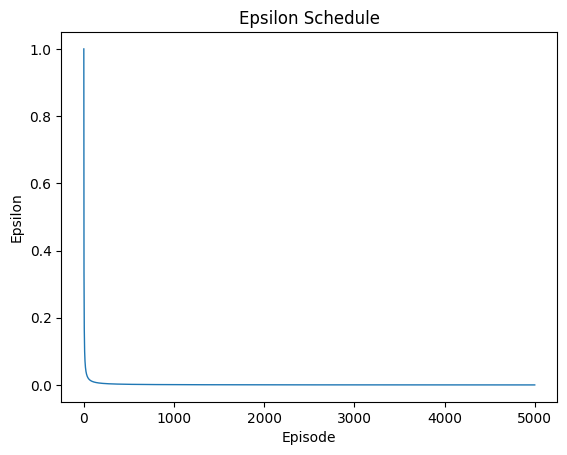

100%|██████████| 5000/5000 [00:02<00:00, 2308.39it/s]


 =========== Q-Table =========== 

   +0.04        +0.03        +0.00        +0.00        
+0.04 +0.48  +0.17 +0.53  +0.00 +0.00  +0.05 +0.00  
   -0.02        -0.41        +0.59        -0.10        

   -0.00        +0.00        +0.00        +0.00        
-0.02 -0.27  +0.00 +0.00  -0.27 -0.27  +0.00 +0.00  
   -0.02        +0.00        +0.66        +0.00        

   -0.00        -0.27        +0.00        +0.00        
-0.00 +0.00  -0.02 +0.20  +0.73 -0.10  +0.00 +0.00  
   -0.19        +0.81        +0.00        +0.00        

   +0.00        +0.07        +0.10        +0.00        
+0.00 +0.00  -0.34 +0.90  +0.15 +1.00  +0.00 +0.00  
   +0.00        -0.01        +0.15        +0.00        



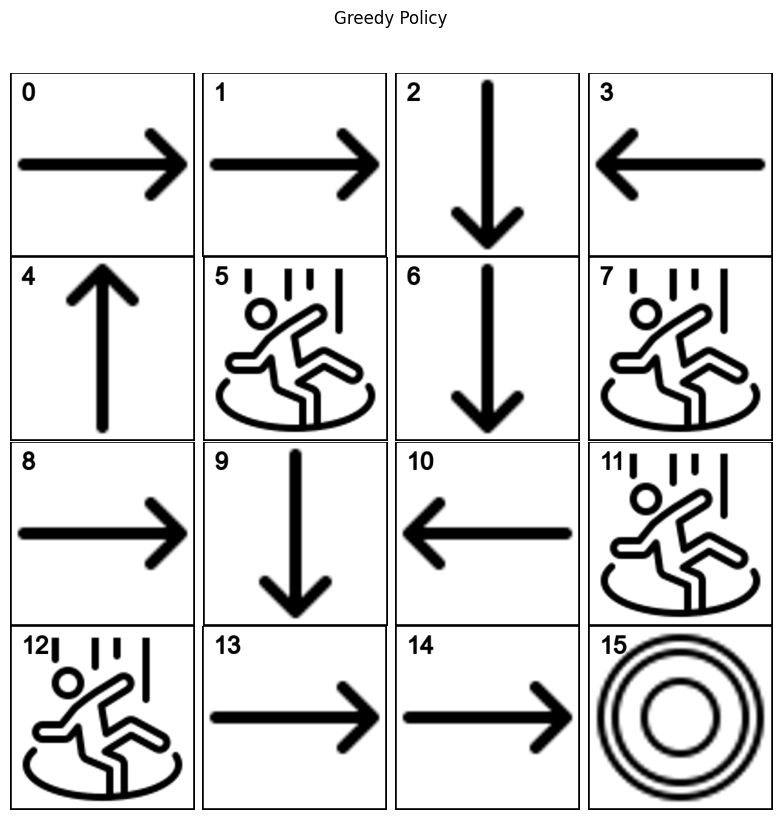

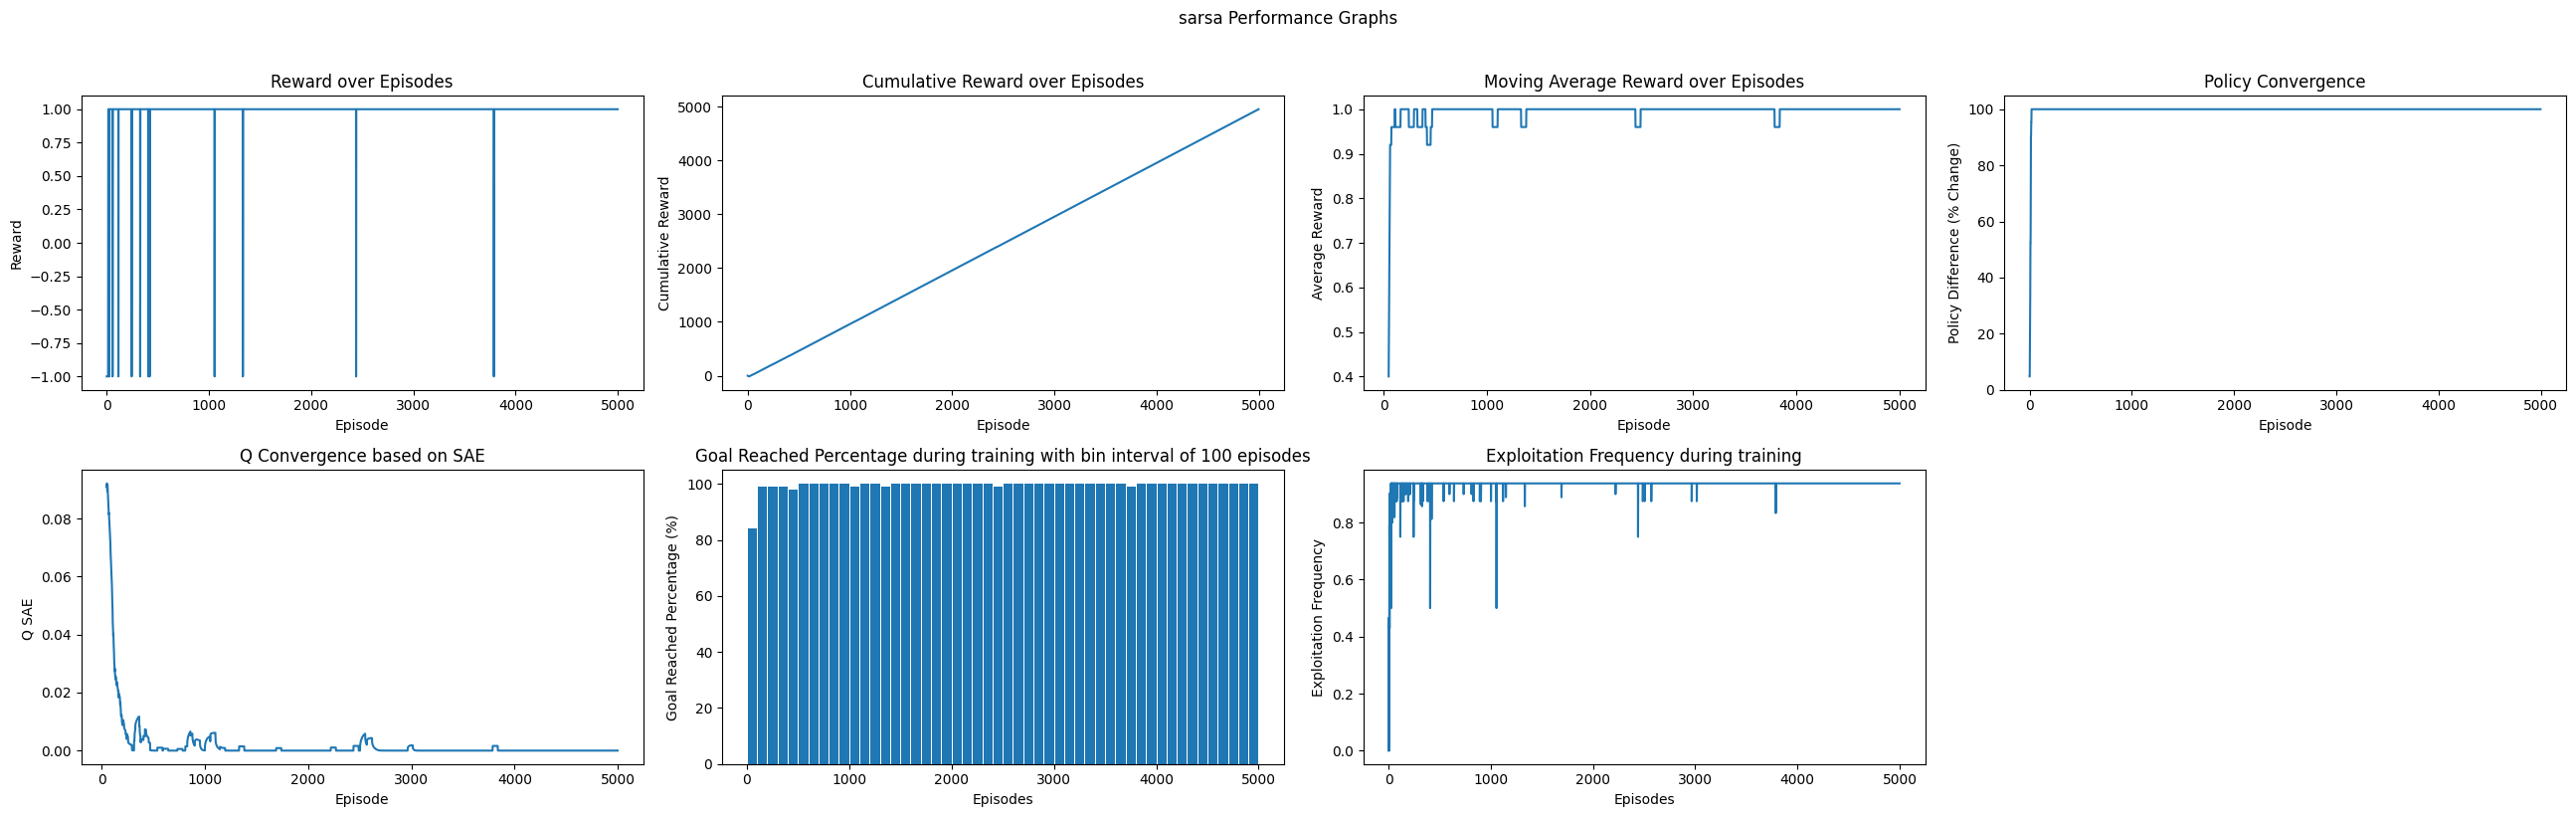

 =========== Training qlearning =========== 


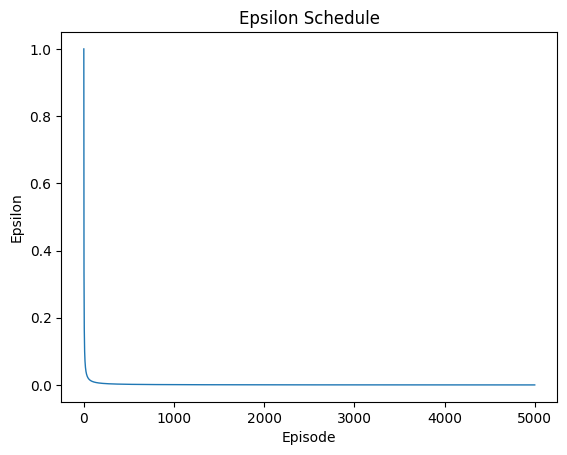

  8%|▊         | 388/5000 [00:11<02:16, 33.87it/s] 


KeyboardInterrupt: 

In [3]:
env = FrozenLake(lake_type = 'original', start_coord = [0,0], frisbee_coord = [3,3])
# env = FrozenLake(lake_type = 'custom', start_coord = [0,0], frisbee_coord = [9,9], hole_fraction=0.25)

algorithm_list = ["sarsa","qlearning"]
combined_total_reward_list = []
combined_policy_diff_list = []
combined_cumulative_reward_list = []
combined_goal_percentage_reached_dict = []

num_episodes = 5000
epsilon = 0.1
epsilon_schedule = 'inverse' #'constant' #'interval' #'linear_drop' #'interval' #'exponential_decay'
epsilon_decay = 0.99975
discount_factor = 0.9
learning_rate = 0.1
epsilon_interval={0:1,0.5:0.5,0.9:0.1}

for algorithm in algorithm_list:
    if algorithm == "monte_carlo_first_visit_no_exploring_starts":
        total_reward_list, cumulative_reward_list, \
        policy_diff_list, goal_percentage_reached_dict = env.train(algorithm=algorithm, 
                                                                    num_episodes=num_episodes,
                                                                    epsilon_schedule=epsilon_schedule,
                                                                    epsilon=epsilon,
                                                                    epsilon_decay=epsilon_decay,
                                                                    discount_factor=discount_factor, 
                                                                    epsilon_interval=epsilon_interval,
                                                                    show_lake=True,
                                                                    show_greedy_policy=True,
                                                                    print_q_table=True,
                                                                    plot_graph=True)
    else:
        total_reward_list, cumulative_reward_list, \
            policy_diff_list, goal_percentage_reached_dict = env.train(algorithm=algorithm, 
                                                                        num_episodes=num_episodes,
                                                                        epsilon_schedule=epsilon_schedule,
                                                                        epsilon=epsilon,
                                                                        epsilon_decay=epsilon_decay,
                                                                        discount_factor=discount_factor, 
                                                                        epsilon_interval=epsilon_interval,
                                                                        learning_rate=learning_rate, 
                                                                        show_greedy_policy=True,
                                                                        print_q_table=True,
                                                                        plot_graph=True)
    combined_total_reward_list.append(total_reward_list)
    combined_cumulative_reward_list.append(cumulative_reward_list)
    combined_policy_diff_list.append(policy_diff_list)
    combined_goal_percentage_reached_dict.append(goal_percentage_reached_dict)
 

# Task 1

## Initial Run
### Parameters:
- Num_Episodes: 1000
- Epsilon: 0.5
- Epsilon Schedule: constant
- Discount Factor: 0.9
- Learning Rate: 0.1


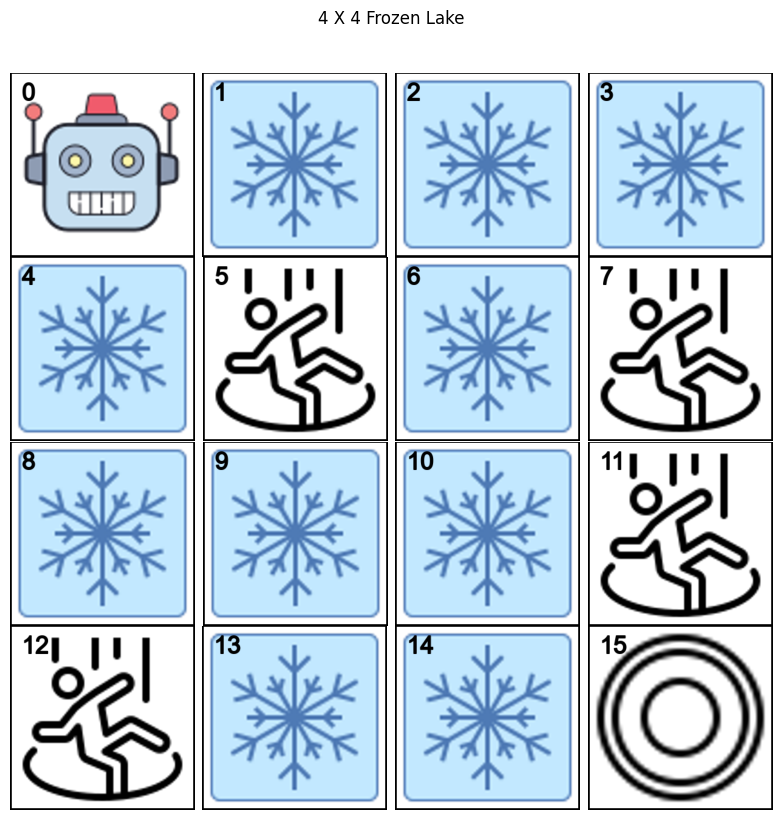

 =========== Training monte_carlo_first_visit_no_exploring_starts =========== 


100%|██████████| 1000/1000 [00:01<00:00, 868.27it/s]


 =========== Q-Table =========== 

   -0.15        -0.27        -0.05        -0.41        
-0.17 -0.21  -0.19 -0.05  -0.27 -0.17  -0.03 -0.27  
   -0.23        -1.00        +0.05        -1.00        

   -0.15        +0.00        -0.10        +0.00        
-0.22 -1.00  +0.00 +0.00  -1.00 -1.00  +0.00 +0.00  
   -0.10        +0.00        +0.43        +0.00        

   -0.19        -1.00        -0.21        +0.00        
-0.15 +0.14  -0.24 +0.32  +0.07 -1.00  +0.00 +0.00  
   -1.00        +0.42        +0.77        +0.00        

   +0.00        -0.02        +0.46        +0.00        
+0.00 +0.00  -1.00 +0.74  +0.42 +1.00  +0.00 +0.00  
   +0.00        +0.36        +0.74        +0.00        



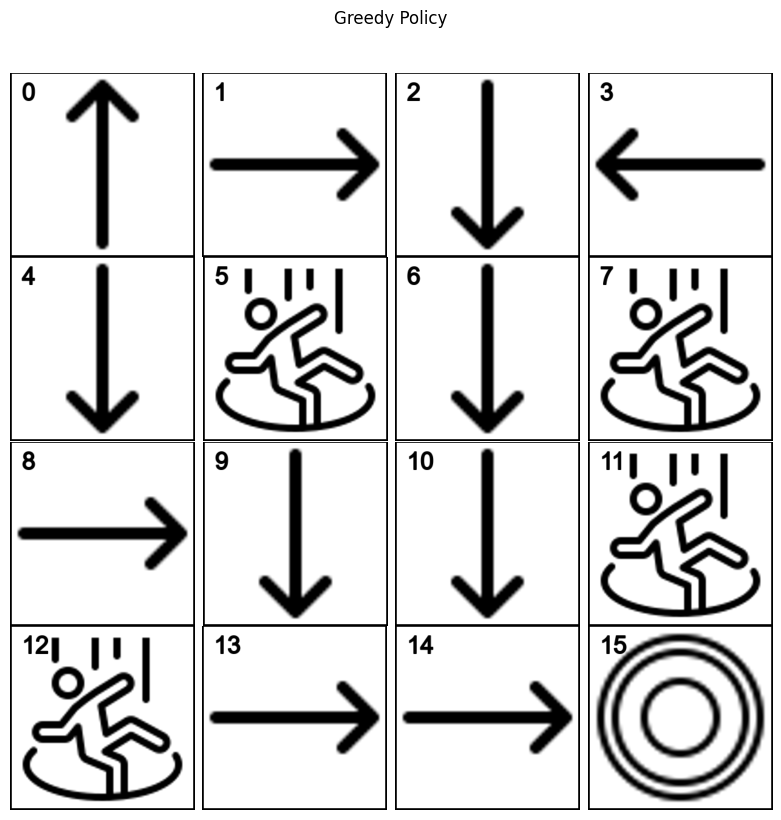

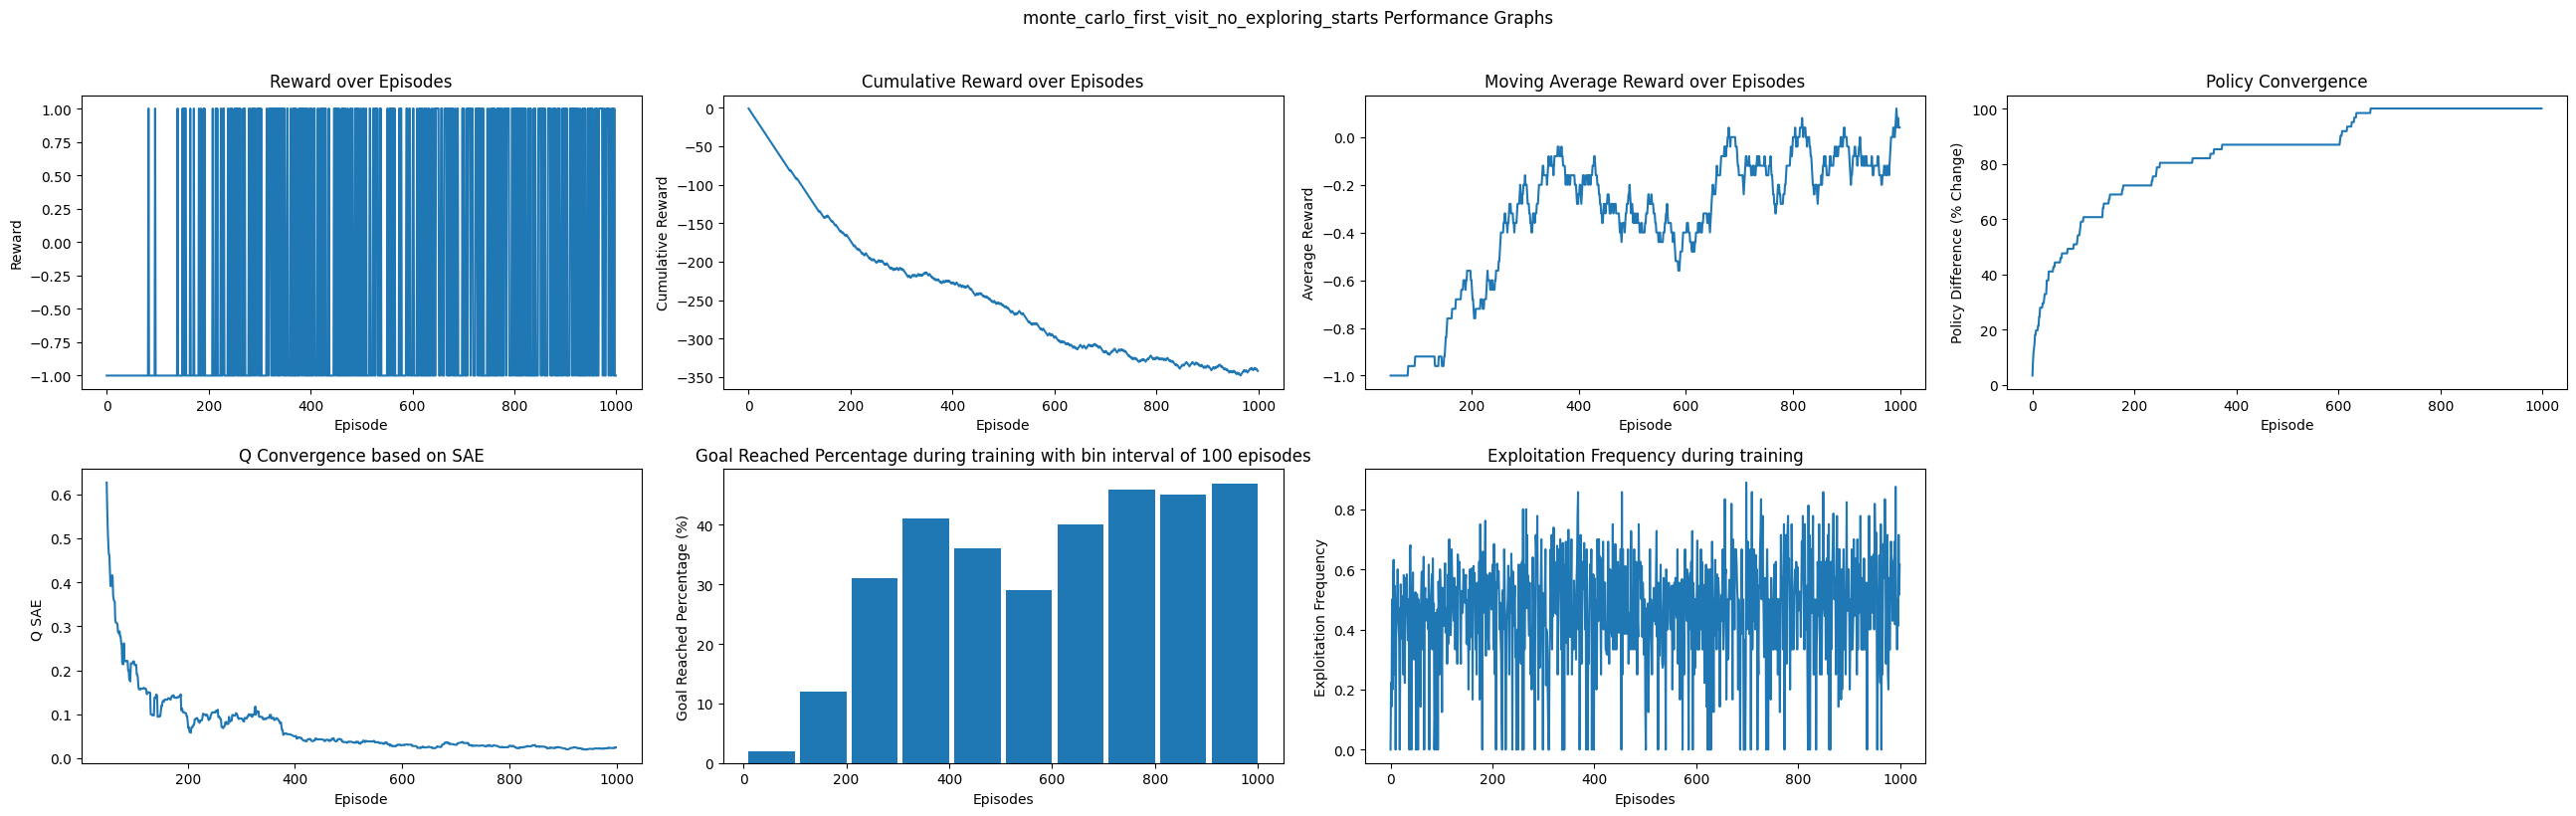

 =========== Training sarsa =========== 


100%|██████████| 1000/1000 [00:00<00:00, 1858.68it/s]


 =========== Q-Table =========== 

   -0.16        -0.25        -0.16        -0.33        
-0.17 -0.26  -0.16 -0.07  -0.25 -0.26  -0.19 -0.32  
   -0.24        -1.00        -0.05        -0.99        

   -0.16        +0.00        -0.12        +0.00        
-0.20 -1.00  +0.00 +0.00  -1.00 -1.00  +0.00 +0.00  
   -0.23        +0.00        +0.32        +0.00        

   -0.27        -0.99        -0.12        +0.00        
-0.22 -0.01  -0.24 +0.40  +0.02 -1.00  +0.00 +0.00  
   -1.00        +0.08        +0.77        +0.00        

   +0.00        +0.02        +0.22        +0.00        
+0.00 +0.00  -0.81 +0.60  +0.28 +1.00  +0.00 +0.00  
   +0.00        +0.19        +0.62        +0.00        



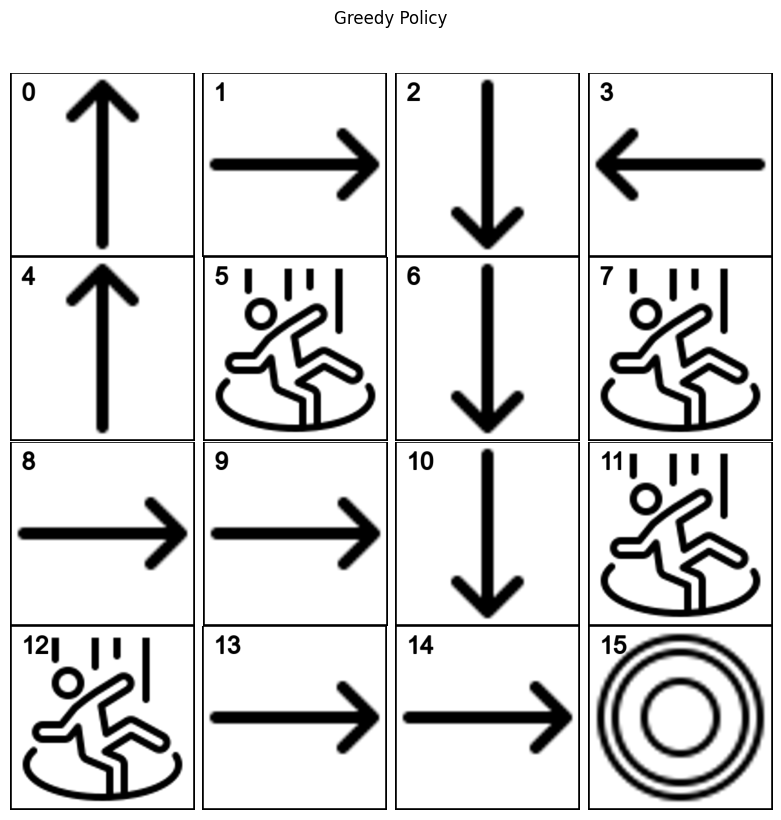

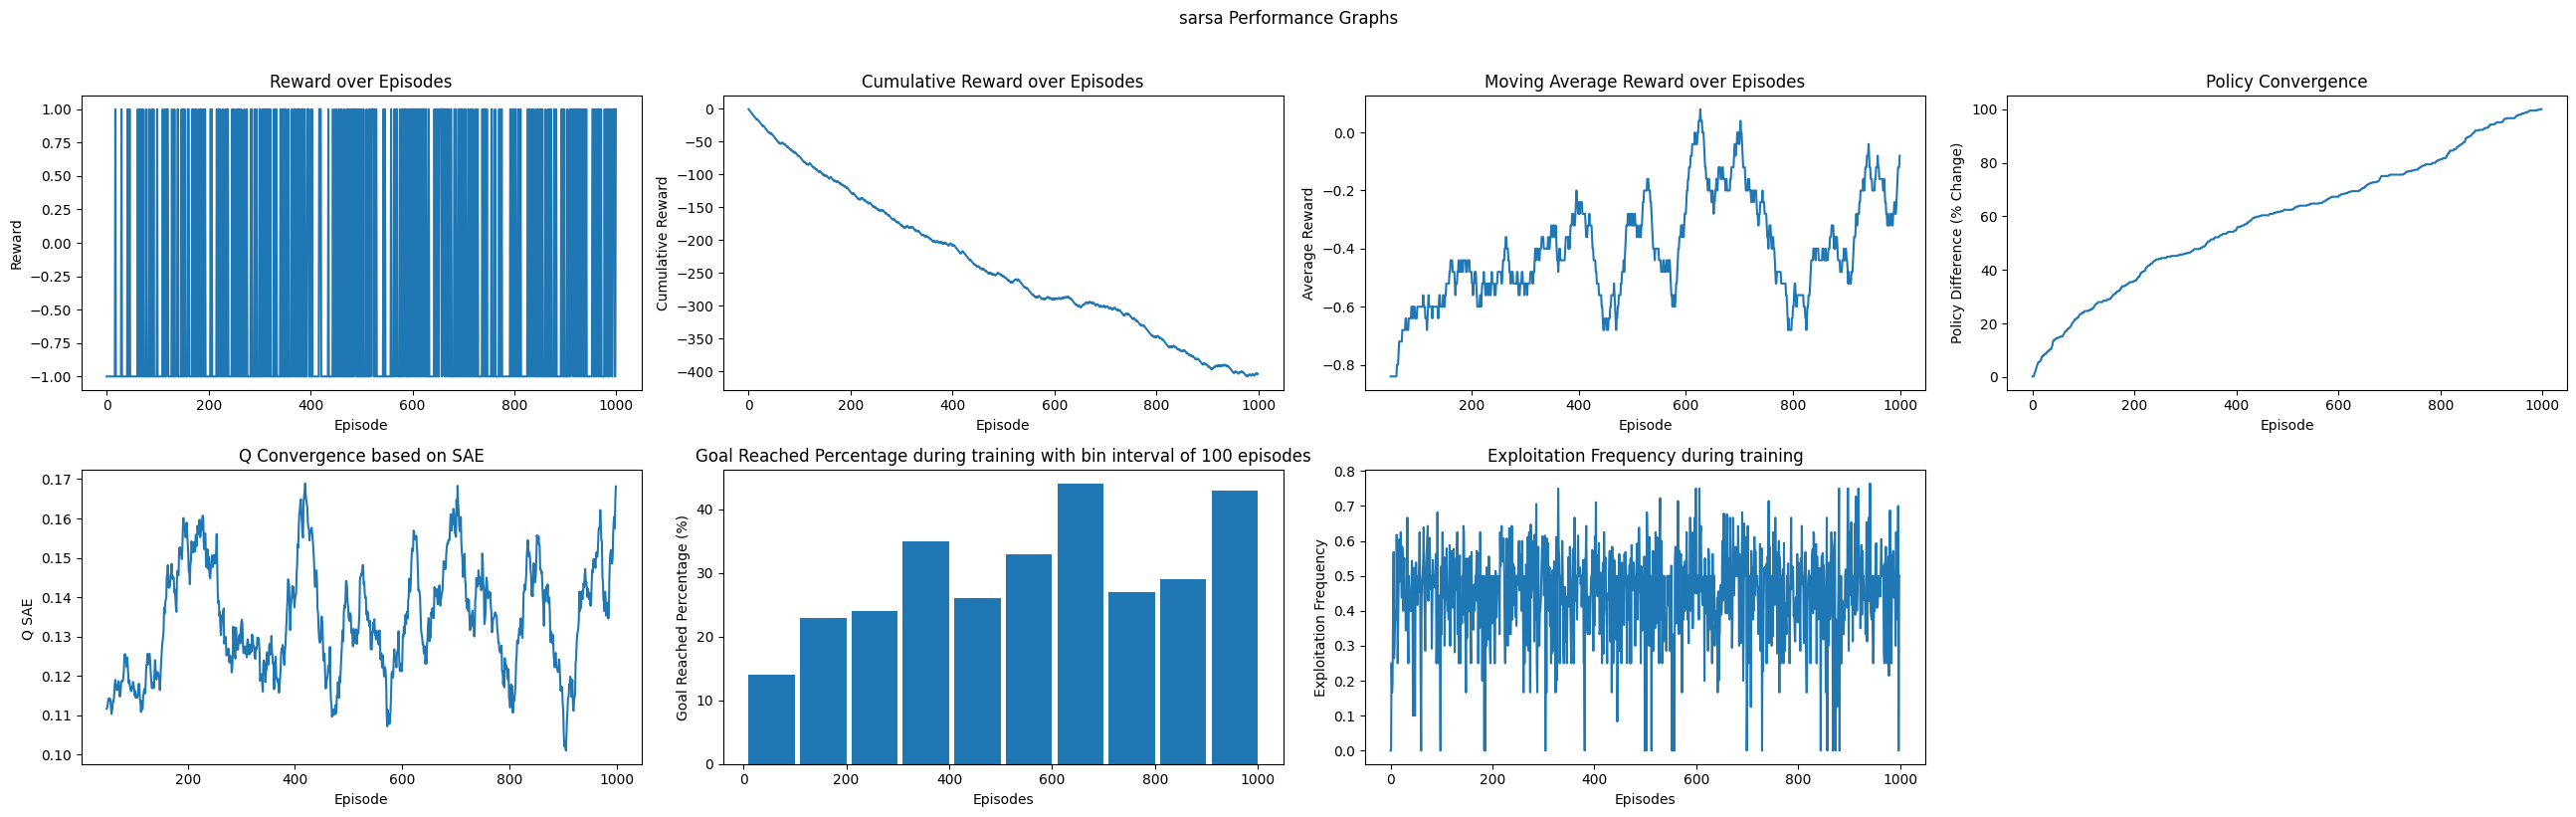

 =========== Training qlearning =========== 


100%|██████████| 1000/1000 [00:00<00:00, 2483.04it/s]


 =========== Q-Table =========== 

   +0.53        +0.45        +0.04        +0.00        
+0.53 +0.48  +0.53 +0.27  +0.17 +0.00  +0.01 +0.00  
   +0.59        -0.99        +0.54        -0.34        

   +0.53        +0.00        +0.12        +0.00        
+0.59 -1.00  +0.00 +0.00  -0.69 -0.65  +0.00 +0.00  
   +0.66        +0.00        +0.77        +0.00        

   +0.59        -1.00        +0.58        +0.00        
+0.66 +0.73  +0.66 +0.81  +0.60 -0.96  +0.00 +0.00  
   -1.00        +0.81        +0.90        +0.00        

   +0.00        +0.73        +0.81        +0.00        
+0.00 +0.00  -1.00 +0.90  +0.81 +1.00  +0.00 +0.00  
   +0.00        +0.81        +0.90        +0.00        



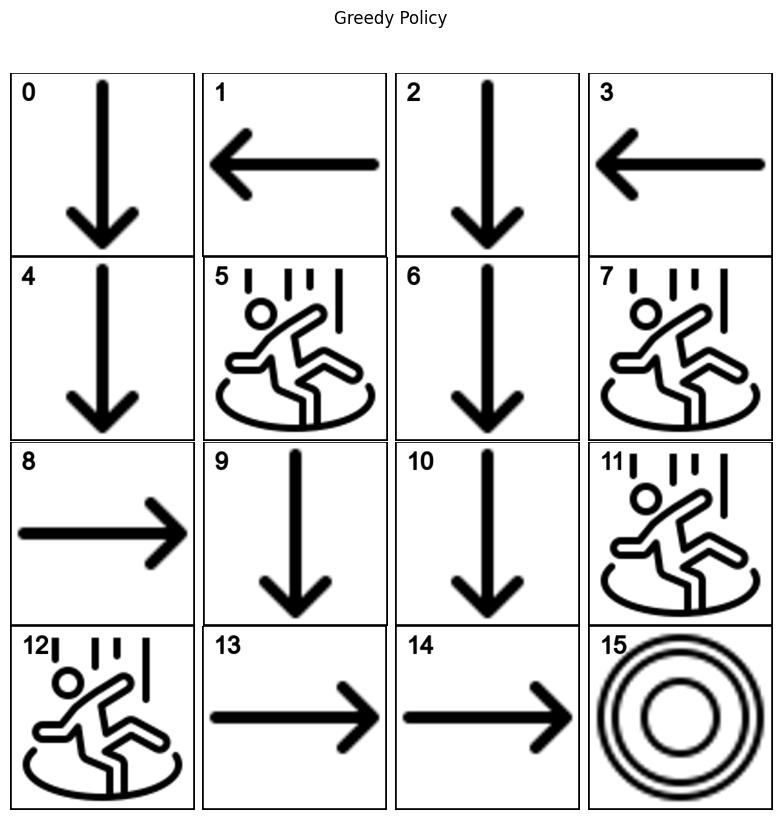

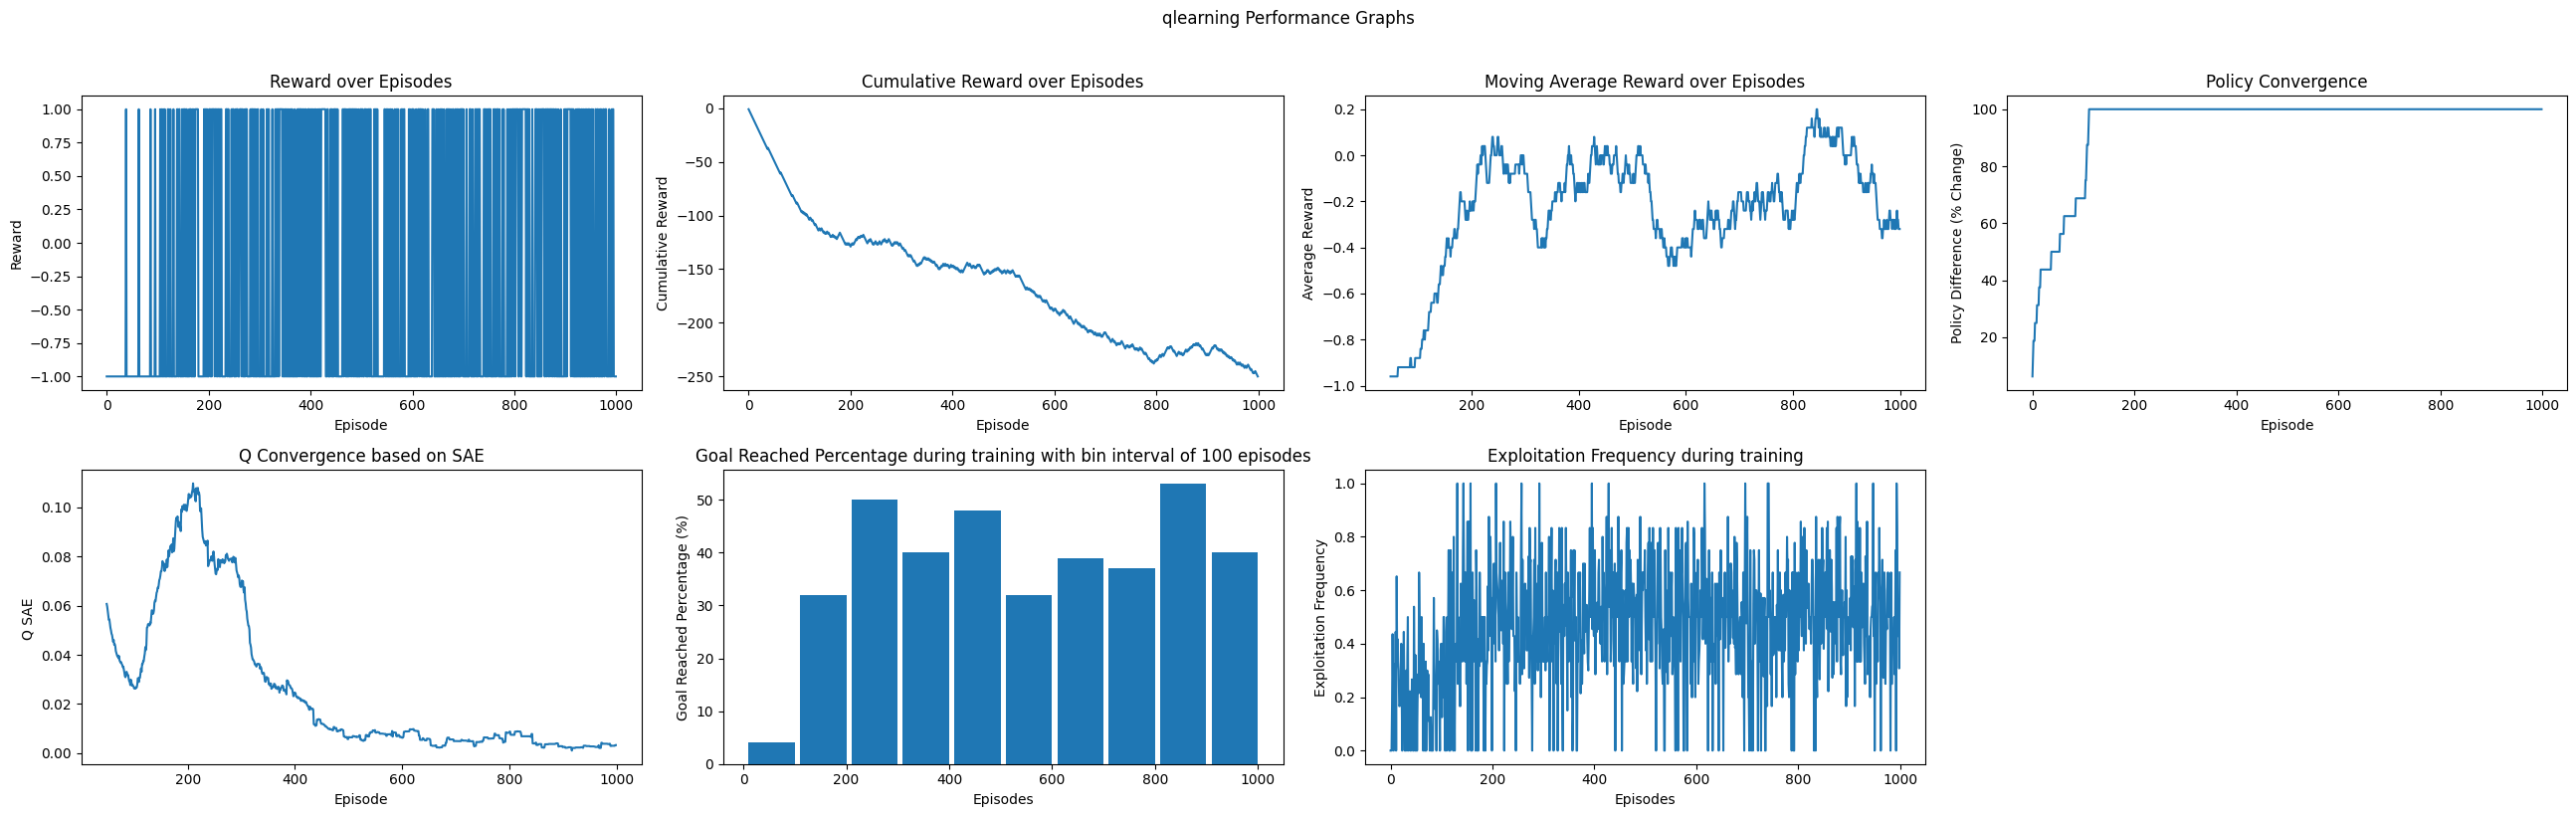

In [4]:
env = FrozenLake(lake_type = 'original', start_coord = [0,0], frisbee_coord = [3,3])
# env = FrozenLake(lake_type = 'custom', start_coord = [0,0], frisbee_coord = [9,9], hole_fraction=0.25)

algorithm_list = ["monte_carlo_first_visit_no_exploring_starts", "sarsa","qlearning"]
combined_total_reward_list = []
combined_policy_diff_list = []
combined_cumulative_reward_list = []
combined_goal_percentage_reached_dict = []

discount_factor = 0.9
num_episodes=1000
epsilon_schedule='constant'
epsilon=0.5
learning_rate = 0.1

for algorithm in algorithm_list:
    if algorithm == "monte_carlo_first_visit_no_exploring_starts":
        total_reward_list, cumulative_reward_list, \
        policy_diff_list, goal_percentage_reached_dict = env.train(algorithm=algorithm, 
                                                                    num_episodes=num_episodes,
                                                                    epsilon_schedule=epsilon_schedule,
                                                                    epsilon=epsilon,
                                                                    discount_factor=discount_factor, 
                                                                    show_lake=True,
                                                                    show_greedy_policy=True,
                                                                    print_q_table=True,
                                                                    plot_graph=True)
    else:
        total_reward_list, cumulative_reward_list, \
            policy_diff_list, goal_percentage_reached_dict = env.train(algorithm=algorithm, 
                                                                        num_episodes=num_episodes,
                                                                        epsilon_schedule=epsilon_schedule,
                                                                        epsilon=epsilon,
                                                                        discount_factor=discount_factor,  
                                                                        learning_rate = learning_rate, 
                                                                        show_greedy_policy=True,
                                                                        print_q_table=True,
                                                                        plot_graph=True)
    combined_total_reward_list.append(total_reward_list)
    combined_cumulative_reward_list.append(cumulative_reward_list)
    combined_policy_diff_list.append(policy_diff_list)
    combined_goal_percentage_reached_dict.append(goal_percentage_reached_dict)
 

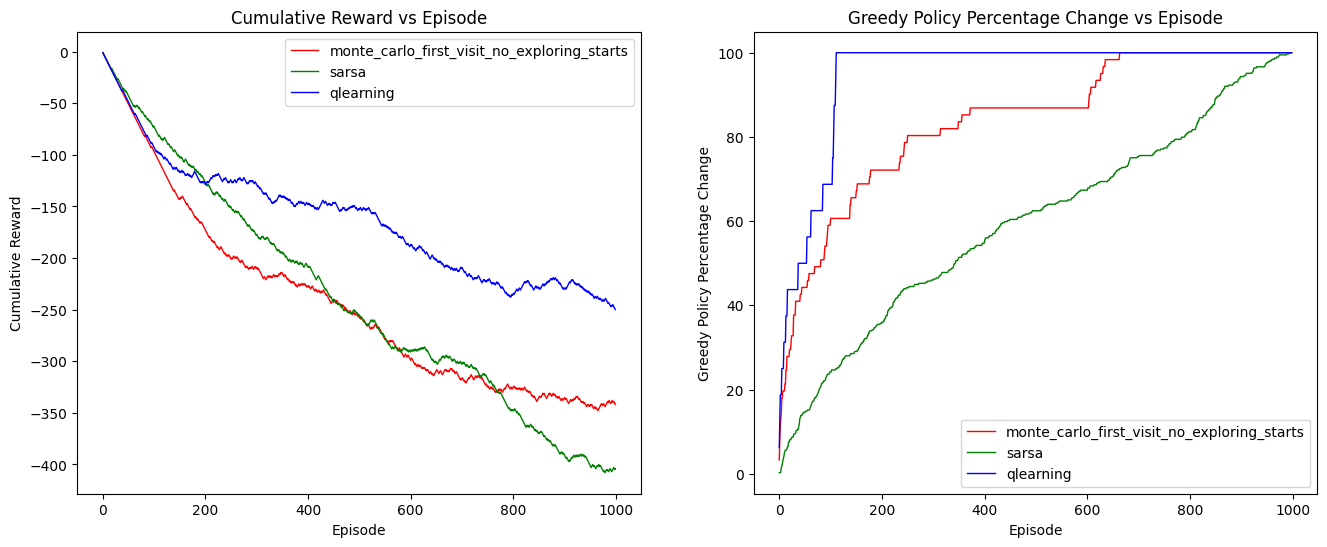

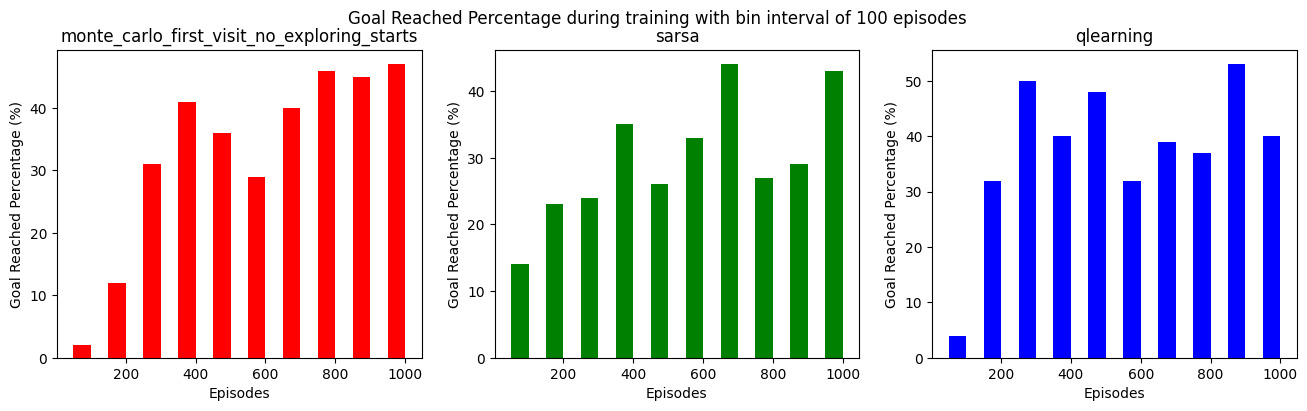

In [5]:
plot_combined_performance_graphs(combined_cumulative_reward_list, combined_policy_diff_list, combined_goal_percentage_reached_dict, algorithm_list)


## Second Run
### Parameters:
- Num_Episodes: 5000
- Epsilon: 1.0
- Epsilon Schedule: exponential_decay
- Discount Factor: 0.9
- Learning Rate: 0.1


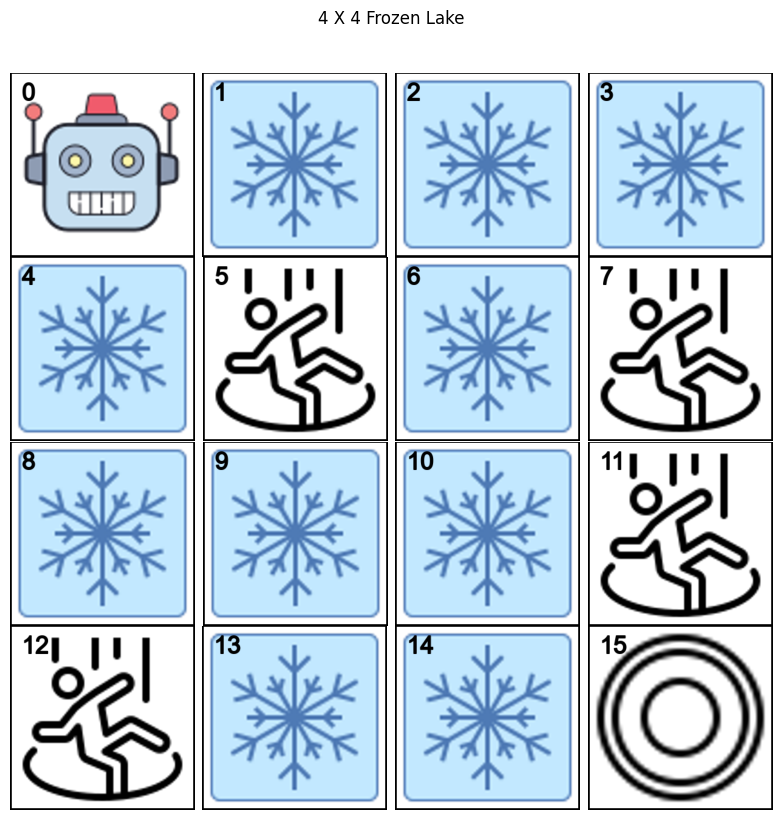

 =========== Training monte_carlo_first_visit_no_exploring_starts =========== 


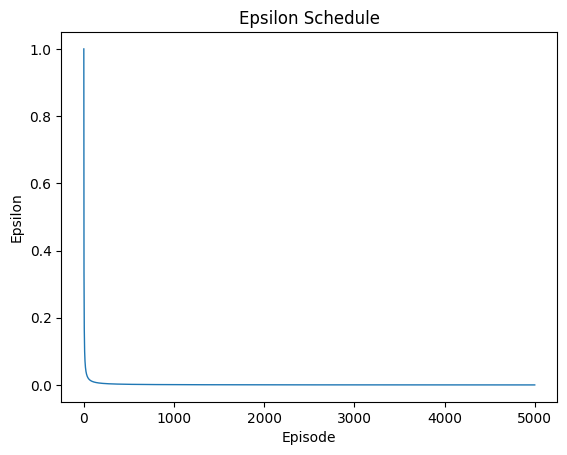

  1%|▏         | 64/5000 [00:30<39:42,  2.07it/s] 


KeyboardInterrupt: 

In [7]:
env = FrozenLake(lake_type = 'original', start_coord = [0,0], frisbee_coord = [3,3])
# env = FrozenLake(lake_type = 'custom', start_coord = [0,0], frisbee_coord = [9,9], hole_fraction=0.25)

algorithm_list = ["monte_carlo_first_visit_no_exploring_starts", "sarsa","qlearning"]
combined_total_reward_list = []
combined_policy_diff_list = []
combined_cumulative_reward_list = []
combined_goal_percentage_reached_dict = []

num_episodes = 5000
epsilon = 0.1
epsilon_schedule = 'inverse' #'constant' #'interval' #'linear_drop' #'interval' #'exponential_decay'
epsilon_decay = 0.99975
discount_factor = 0.9
learning_rate = 0.1
epsilon_interval={0:1,0.5:0.5,0.9:0.1}

for algorithm in algorithm_list:
    if algorithm == "monte_carlo_first_visit_no_exploring_starts":
        total_reward_list, cumulative_reward_list, \
        policy_diff_list, goal_percentage_reached_dict = env.train(algorithm=algorithm, 
                                                                    num_episodes=num_episodes,
                                                                    epsilon_schedule=epsilon_schedule,
                                                                    epsilon=epsilon,
                                                                    epsilon_decay=epsilon_decay,
                                                                    discount_factor=discount_factor, 
                                                                    epsilon_interval=epsilon_interval,
                                                                    show_lake=True,
                                                                    show_greedy_policy=True,
                                                                    print_q_table=True,
                                                                    plot_graph=True)
    else:
        total_reward_list, cumulative_reward_list, \
            policy_diff_list, goal_percentage_reached_dict = env.train(algorithm=algorithm, 
                                                                        num_episodes=num_episodes,
                                                                        epsilon_schedule=epsilon_schedule,
                                                                        epsilon=epsilon,
                                                                        epsilon_decay=epsilon_decay,
                                                                        discount_factor=discount_factor, 
                                                                        epsilon_interval=epsilon_interval,
                                                                        learning_rate=learning_rate, 
                                                                        show_greedy_policy=True,
                                                                        print_q_table=True,
                                                                        plot_graph=True)
    combined_total_reward_list.append(total_reward_list)
    combined_cumulative_reward_list.append(cumulative_reward_list)
    combined_policy_diff_list.append(policy_diff_list)
    combined_goal_percentage_reached_dict.append(goal_percentage_reached_dict)
 

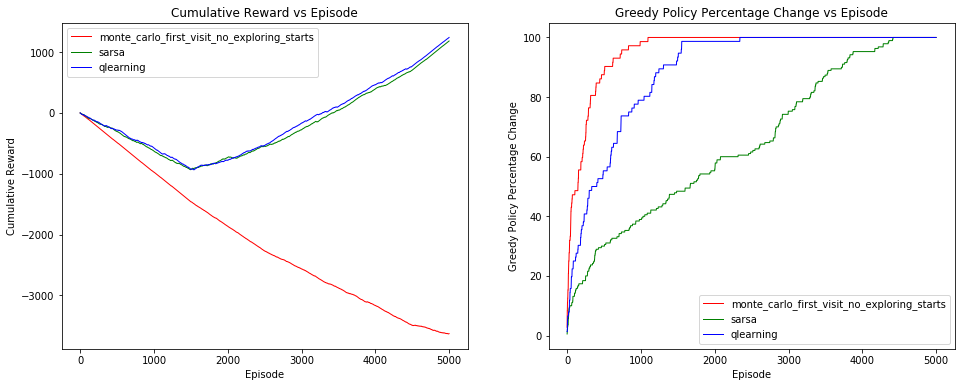

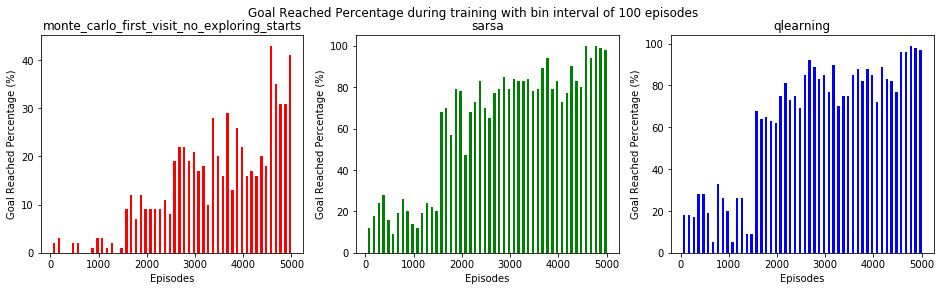

In [27]:
plot_combined_performance_graphs(combined_cumulative_reward_list, combined_policy_diff_list, combined_goal_percentage_reached_dict, algorithm_list)


## Hyperparameter Tuning

In [ ]:
env = FrozenLake(lake_type = 'original', start_coord = [0,0], frisbee_coord = [3,3])
# env = FrozenLake(lake_type = 'custom', start_coord = [0,0], frisbee_coord = [9,9], hole_fraction=0.25)

algorithm_list = ["monte_carlo_first_visit_no_exploring_starts", "sarsa","qlearning"]
combined_total_reward_list = []
combined_policy_diff_list = []
combined_cumulative_reward_list = []
combined_goal_percentage_reached_dict = []

num_episodes = 5000
epsilon = 1
epsilon_schedule = 'interval' #'constant' #'interval' #'linear_drop' #'interval' #'exponential_decay'
epsilon_decay = 0.99975
discount_factor = 0.9
learning_rate = 0.1
epsilon_interval={0:1,0.5:0.5,0.9:0.1}

algorithm = "qlearning"
learning_rate_list = [0.001,0.005,0.01,0.1,0.5,1]
for learning_rate in learning_rate_list:
    # for algorithm in algorithm_list:
    #     if algorithm == "monte_carlo_first_visit_no_exploring_starts":
    #         total_reward_list, cumulative_reward_list, \
    #         policy_diff_list, goal_percentage_reached_dict = env.train(algorithm=algorithm, 
    #                                                                     num_episodes=num_episodes,
    #                                                                     epsilon_schedule=epsilon_schedule,
    #                                                                     epsilon=epsilon,
    #                                                                     epsilon_decay=epsilon_decay,
    #                                                                     discount_factor=discount_factor, 
    #                                                                     epsilon_interval=epsilon_interval,
    #                                                                     show_lake=True,
    #                                                                     show_greedy_policy=True,
    #                                                                     print_q_table=True,
    #                                                                     plot_graph=True)
        # else:
    total_reward_list, cumulative_reward_list, \
        policy_diff_list, goal_percentage_reached_dict = env.train(algorithm=algorithm, 
                                                                    num_episodes=num_episodes,
                                                                    epsilon_schedule=epsilon_schedule,
                                                                    epsilon=epsilon,
                                                                    epsilon_decay=epsilon_decay,
                                                                    discount_factor=discount_factor, 
                                                                    epsilon_interval=epsilon_interval,
                                                                    learning_rate=learning_rate, 
                                                                    show_greedy_policy=True,
                                                                    print_q_table=True,
                                                                    plot_graph=True)

## Task 2: 10 x 10 FrozenLake

In [6]:
# env = FrozenLake(lake_type = 'original', start_coord = [0,0], frisbee_coord = [3,3])
env = FrozenLake(lake_type = 'custom', start_coord = [0,0], frisbee_coord = [9,9], hole_fraction=0.25)

algorithm_list = ["monte_carlo_first_visit_no_exploring_starts", "sarsa","qlearning"]
combined_total_reward_list = []
combined_policy_diff_list = []
combined_cumulative_reward_list = []
combined_goal_percentage_reached_dict = []

discount_factor = 0.9
num_episodes=100000
epsilon_schedule='exponential_decay' #'constant'
epsilon=1.0 #0.5
epsilon_decay = 0.99999
learning_rate=0.1

for algorithm in algorithm_list:
    if algorithm == "monte_carlo_first_visit_no_exploring_starts":
        total_reward_list, cumulative_reward_list, \
        policy_diff_list, goal_percentage_reached_dict = env.train(algorithm=algorithm, 
                                                                    num_episodes=num_episodes,
                                                                    epsilon_schedule=epsilon_schedule,
                                                                    epsilon=epsilon,
                                                                    epsilon_decay=epsilon_decay,
                                                                    discount_factor=discount_factor, 
                                                                    show_lake=True,
                                                                    show_greedy_policy=True,
                                                                    print_q_table=True,
                                                                    plot_graph=True)
    else:
        total_reward_list, cumulative_reward_list, \
            policy_diff_list, goal_percentage_reached_dict = env.train(algorithm=algorithm, 
                                                                        num_episodes=num_episodes,
                                                                        epsilon_schedule=epsilon_schedule,
                                                                        epsilon=epsilon,
                                                                        discount_factor=discount_factor,  
                                                                        epsilon_decay=epsilon_decay,
                                                                        learning_rate = learning_rate, 
                                                                        show_greedy_policy=True,
                                                                        print_q_table=True,
                                                                        plot_graph=True)
    combined_total_reward_list.append(total_reward_list)
    combined_cumulative_reward_list.append(cumulative_reward_list)
    combined_policy_diff_list.append(policy_diff_list)
    combined_goal_percentage_reached_dict.append(goal_percentage_reached_dict)
 

25
Holes picked were: ['49', '2', '29', '42', '86', '65', '7', '36', '6', '46', '82', '63', '16', '89', '20', '88', '32', '79', '98', '52', '30', '91', '59', '84', '77']
However, this hole configuration does not result in a valid path from agent start state to frisbee state. Trying again by randomly picking holes...
26


In [ ]:
def create_epsilon_schedule(num_episodes,  \
                       epsilon_start=1.0, epsilon_decay=.99, epsilon_min=1e-4):
    x = np.arange(num_episodes)+1
    # y = np.full(num_episodes, epsilon_start)
    y = np.maximum((epsilon_decay**x)*epsilon_start, epsilon_min)
    return y
def plot_schedule(epsilon_schedule, ylab = 'Epsilon'):
    plt.plot(np.arange(len(epsilon_schedule)), epsilon_schedule, linewidth=1)

    plt.title('Epsilon Schedule')
    plt.xlabel('Episode')
    plt.ylabel(ylab)
    plt.legend(loc='best')
    plt.show()
epsilon_schedule = create_epsilon_schedule(1000)
plot_schedule(epsilon_schedule, ylab = 'Epsilon')

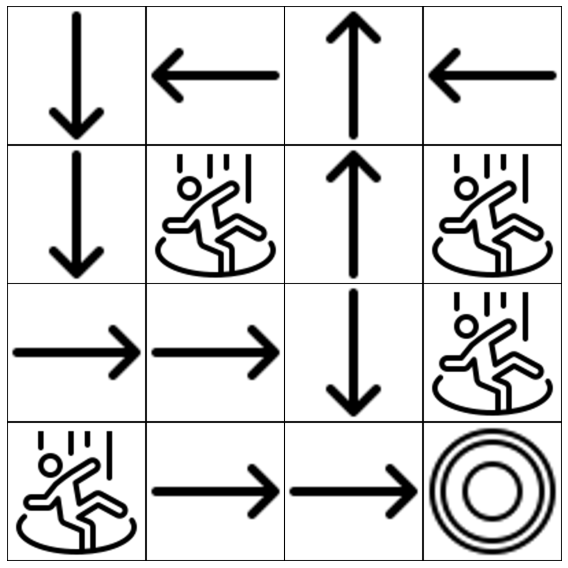

In [44]:
import math
import pathlib
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

output_dir = pathlib.Path("./images")
images = list(output_dir.glob('*.png'))


greedy_policy = ['D', 'L', 'U', 'L', 'D', '✛', 'U', '✛', 'R', 'R', 'D', '✛', '✛', 'R', 'R', '✛']
# col = 4
# image_count = len(images)
# row = math.ceil(image_count/col)
col = 4
row = 4
plt.figure(figsize=(col*2,row*2))

def choose_img(img_path):
    img_path = str(img_path)
    img = Image.open(img_path)
    img = img.resize((300,300))
    img = ImageOps.expand(img,border=2,fill='black')
    return img

start_state = 0
frisbee_state = 15
hole_states = [5,7,11,12]
# for i, img_path in enumerate(images):
for i, action in enumerate(greedy_policy):
    if i == frisbee_state:
        img = choose_img(img_path='./images/frisbee.png')
    elif i in hole_states:
        img = choose_img(img_path='./images/hole.png')
    elif action == 'D':
        img = choose_img(img_path='./images/down.png')
    elif action == 'L':
        img = choose_img(img_path='./images/left.png')
    elif action == 'R':
        img = choose_img(img_path='./images/right.png')
    elif action == 'U':
        img = choose_img(img_path='./images/up.png')
    else:
        img = choose_img(img_path='./images/cross.png')

    plt.subplot(row, col, i + 1)
    plt.imshow(img)

    plt.axis("off")
plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0) 
plt.show()
plt.close()